# Тестовое задание

## Общие данные по проекту

Компания разрабатывает систему для умной фермы, которая позволяет контролировать рост птиц на ферме. У нас есть клиенты, у которых несколько ферм. В каждой ферме может быть несколько птичников (houses), где установлены наши камеры. В House друг за дружкой идут циклы. Цикл - вся жизнь птичек от рождения до… поездки на завод.)
В течение всего цикла наша система наблюдает за птичками и следит за тем, как хорошо они растут.

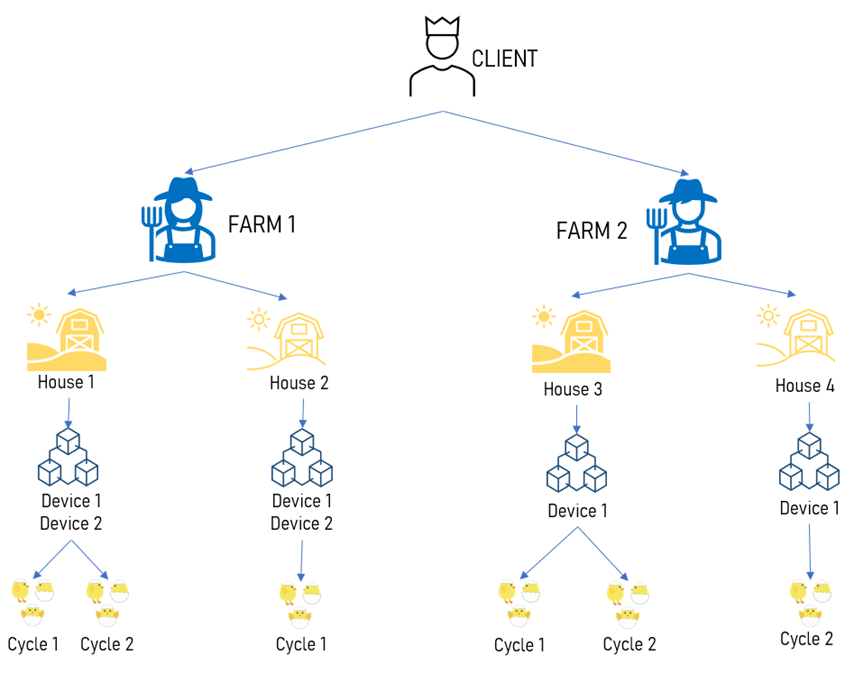

**Задача проекта**

**Задание 1.**  
Подготовлен датасет. В нем находятся собранные нашей системой фичи птиц. Фичи усреднены по дню и представляют собой усредненное значение по нескольким тысячам птиц, пробегающих мимо наших камер. Пока это все, что у нас есть для обучения модели и наиболее точного предсказания target_mass (которая тоже есть в этом датасете).

*При этом важно учитывать следующие особенности бизнеса:*    
- Заявленная точность системы в последние дни - 95% (MAPE = 5%);  
- Фермеров больше всего волнует точность нашего предсказания веса в возрастах 35+, однако остальные возраста тоже имеют значение, но поменьше;  
- Заказчик скорее всего будет возмущаться по поводу каждого cycle-house, у которого ошибка в последние дни будет больше 5%. Было бы хорошо знать, к чему нам готовиться ещё на моменте обучения модели;  

*Что нужно сделать:*   
1.	Выявить наиболее влиятельные фичи, чтобы использовать их в обучении (расскажи, каким методом ты пользуешься);  
2.	Придумать метрики, которые позволят выбрать наилучшую модель;  
3.	Раздели весь датасет на трейн/тест/валидацию и опиши, как ты это делаешь;  
4.	Обучить модели на предсказ массы по дням и выбрать лучшую модель по метрикам из пункта 2 (подготовь код запуска и саму модель/несколько моделей, чтобы передать нам - мы потестируем её на специально отложенном тесте, куда входят другие cycle-houses).  

**Задание 2.**  
Предположи вероятные причины больших ошибок в разных частях цикла и причины аутлаерности разных cycle-houses (если есть где-то постоянно высокие ошибки в какой-то части цикла).  

**Задание 3.**  
Выяснилось, что некоторые фермы в некоторых cycle-houses тайком отгружают толстеньких птичек на сторону без ведома начальства. При этом, чтобы не засветиться, ручные взвешивания, которые они докладывают начальству, завышены относительно реальных. И эти завышенные веса попадают к нам в таргет и портят нам выборку. Попробуй предположить, в каких cycle-houses такое могло произойти. Надо быть точно уверенными, потому что если мы обвиним честных фермеров в таком, то можем потерять клиента.  


**Описание полей данных**
- **client** - клиент
- **farm** - ферма (под клиентом) 
- **house** - птичник на ферме 
- **cycle** - цикл жизни одного помета птиц (от вылупления до поездки на завод) 
- **daynum** - возраст птиц (в днях) 
- **count** - число распознанных птиц с наших камер в хаусе 
- **confidence** - "уверенность в качестве картинок (измеряется от 0 до 1): 
                    0 - совсем плохо, результаты, полученные с этих картинок, сомнительные; 
                    1 - все хорошо, картинкам можно доверять"
- **predicted_dummy_model_mean** - предсказанное значение средней массы птиц с помощью одной из рандомных моделек 
- **feature_1** - различные геометрические фичи птиц, полученные из моделей компьютерного зрения 
- **feature_2** - различные геометрические фичи птиц, полученные из моделей компьютерного зрения 
- **feature_3** - различные геометрические фичи птиц, полученные из моделей компьютерного зрения 
- **feature_4** - различные геометрические фичи птиц, полученные из моделей компьютерного зрения 
- **target_mass** - таргет вес (основанный на ручных взвешиваниях фермеров, на заводском весе в первый день и последний день жизни птиц)

## Разведывательный анализ данных

### Импортируем нужные библиотеки и настройки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats as st
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import kstest
from typing import Dict, Any
from datetime import datetime as dt
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
import datetime
# import ptitprince as pt
import re
from pandas import DataFrame

pd.set_option('display.max_columns', None)
pd.set_option("display.float_format", "{:,.2f}".format)

import warnings
warnings.filterwarnings('ignore')
from typing import List
from skimpy import clean_columns
from phik import phik_matrix
from phik import resources, report

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectFromModel

In [3]:
random_state = 121

### Импортируем датасеты

In [4]:
way = 'C:/zzz'

In [5]:
df = pd.read_csv(way + '/dataset_fluffy.csv', sep=';')

Решил, что для вас профайлрепорт может показаться дурным тоном, поэтому убрал его и написал функцию

In [6]:
# from pandas_profiling import ProfileReport

In [7]:
# ProfileReport(df.sample(5000), minimal=True)

### Напишем функцию для получения полной инфы по каждому датафрейму

In [8]:
def information(df: DataFrame, name: str) -> None:
    '''
    Функция напечатает информацию по датасету: первые 10 строк,
    название столбцов, кол-во строк и их тип, кол-во пропущенных значений, 
    полные дубликаты
    '''
    pd.options.display.max_rows = 1000
    print('*'*30,name,'*'*30)
    print()
    display(df.head(10))
    print('-'*25,'INFO','-'*25)
    print()
    print(df.info())
    print()
    print('-'*10,'NAN','-'*10)
    print()
    print(df.isna().sum())
    print()
    print('-'*5,'DESCRIBE','-'*5)
    print(df.describe())
    print()
    print('-'*5,'DUPLICATED','-'*5)
    print(df.duplicated().sum())
    print()
    print('-'*25,'UNIQUE VALUES','-'*25)
    for column in df.columns:
        print(column)
        print(df[column].unique())
        print('+'*25)

**Приведём все столбцы к змеиному регистру, если требуется**

In [9]:
df = clean_columns(df)

0 column names have been cleaned

### anket

In [10]:
information(df, 'DF')

****************************** DF ******************************



,client,farm,house,cycle,daynum,count,confidence,predicted_dummy_model_mean,feature_1,feature_2,feature_3,feature_4,target_mass
0,ChickenQueen,Mister Fantastic,House 12,Cycle 1,2,4097,0.01,0.06,0.13,7.92,5.04,4.11,0.05
1,ChickenQueen,Mister Fantastic,House 12,Cycle 1,3,7845,0.01,0.07,0.15,8.21,5.24,3.92,0.07
2,ChickenQueen,Mister Fantastic,House 12,Cycle 1,4,3275,0.20,0.10,0.20,9.09,5.76,4.41,0.08
3,ChickenQueen,Mister Fantastic,House 12,Cycle 1,5,2815,0.16,0.12,0.23,9.50,6.01,4.59,0.10
4,ChickenQueen,Mister Fantastic,House 12,Cycle 1,6,7621,0.20,0.15,0.30,10.47,6.69,4.75,0.11
5,ChickenQueen,Mister Fantastic,House 12,Cycle 1,7,7331,0.19,0.18,0.33,10.71,6.86,5.22,0.13
6,ChickenQueen,Mister Fantastic,House 12,Cycle 1,8,5311,0.16,0.20,0.35,11.15,6.89,5.74,0.16
7,ChickenQueen,Mister Fantastic,House 12,Cycle 1,9,4467,0.19,0.22,0.40,11.85,7.27,5.47,0.18
8,ChickenQueen,Mister Fantastic,House 12,Cycle 1,11,2972,0.21,0.29,0.53,12.78,7.95,7.09,0.25
9,ChickenQueen,Mister Fantastic,House 12,Cycle 1,12,2293,0.25,0.35,0.63,13.22,8.53,6.54,0.28


------------------------- INFO -------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048 entries, 0 to 1047
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   client                      1048 non-null   object 
 1   farm                        1048 non-null   object 
 2   house                       1048 non-null   object 
 3   cycle                       1048 non-null   object 
 4   daynum                      1048 non-null   int64  
 5   count                       1048 non-null   int64  
 6   confidence                  1048 non-null   float64
 7   predicted_dummy_model_mean  1048 non-null   float64
 8   feature_1                   1048 non-null   float64
 9   feature_2                   1048 non-null   float64
 10  feature_3                   1048 non-null   float64
 11  feature_4                   1048 non-null   float64
 12  target_mass                 1048

Уберем сразу столбец клиента, так как он один и тот же

In [12]:
df.drop(columns='client', inplace=True)

Создадим списки с категориальными и цифровыми столбцами. Столбцы типа объект переведем в соответствующий тип

In [14]:
cat = [col for col in df.columns if df[col].dtype == 'object']
numeric = list(df.select_dtypes(include=['int64', 'float64']).columns)

In [15]:
df[cat] = df[cat].astype('category')

**Напишем функции графиков, которыми будем пользоваться**

In [16]:
def cat_bar(df: DataFrame, axes: int, col: str, hue: str = None) -> None:
    '''
    Функция построит барплот для категориального столбца датафрейма
    '''
    plt.subplot(axes)
    if hue:
        # Если передан параметр hue, строим график с разбивкой на категории
        groups = df.groupby([col, hue]).size().unstack()
        groups.plot(kind='bar', stacked=True, ax=plt.gca(), rot=0)
    else:
        # Иначе строим график для одной категории
        plt.bar(df[col].unique(), df[col].value_counts(), color='steelblue', edgecolor='white', alpha=0.8, width=0.6)
    plt.grid(axis='y', alpha=0.7)
    plt.xticks(rotation=90)
    plt.title(col)
    plt.ylabel('Количество')

In [17]:
def plot_distribution(df: pd.DataFrame, columns: List[str], hue_column: str, bins: int = 20, kde: bool = False) -> None:
    """
    Функция строит графики распределения для столбцов датафрейма с учетом группировки по параметру hue_column
    """
    for column in columns:
        try:
            plt.figure(figsize=(8, 5))
            sns.histplot(data=df, x=column, hue=hue_column, bins=bins, kde=False)
            plt.title(f'Distribution of {column}')
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.show()
        except Exception as e:
            print(f"An error occurred while plotting {column} by {hue_column}: {e}")

In [18]:
def plot_boxplot(df: pd.DataFrame, columns: List[str], hue_column: str) -> None:
    """
    Функция строит боксплоты для столбцов датафрейма с учетом группировки по параметру hue_column
    """
    for column in columns:
        try:
            plt.figure(figsize=(8, 5))
            sns.boxplot(data=df, x=hue_column, y=column)
            plt.title(f'Boxplot of {column}')
            plt.xlabel(hue_column)
            plt.ylabel(column)
            plt.show()
        except Exception as e:
            print(f"An error occurred while plotting {column} by {hue_column}: {e}")

Предварительно посмотрим на распределение столбцов

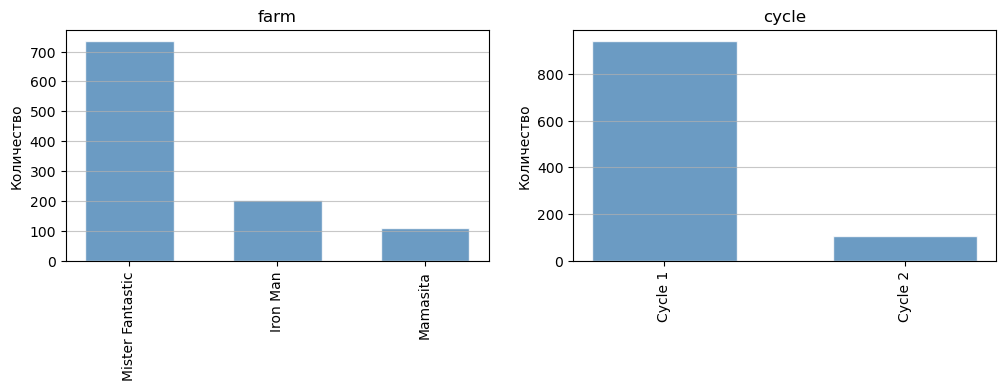

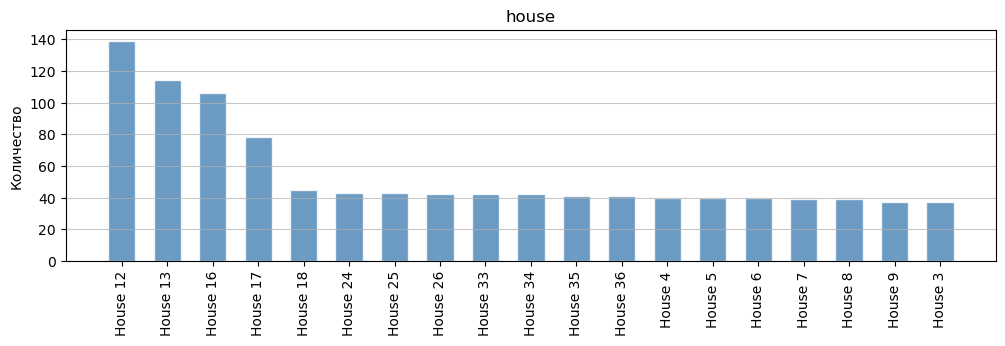

In [19]:
plt.figure(figsize=(12, 3))
cat_bar(df, 121, cat[0])
cat_bar(df, 122, cat[2])
plt.figure(figsize=(12, 3))
cat_bar(df, 111, cat[1])

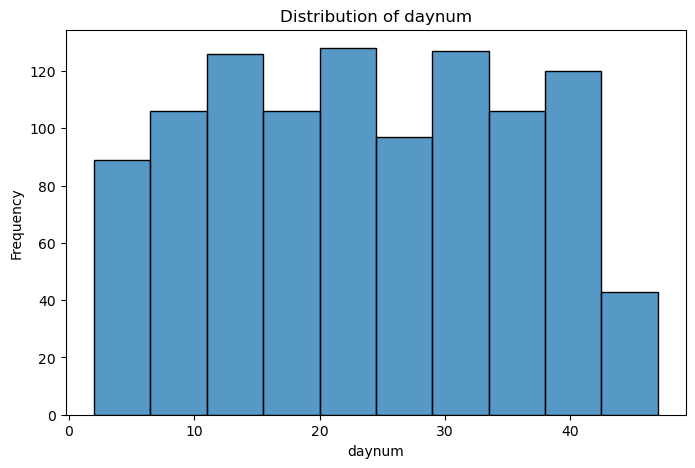

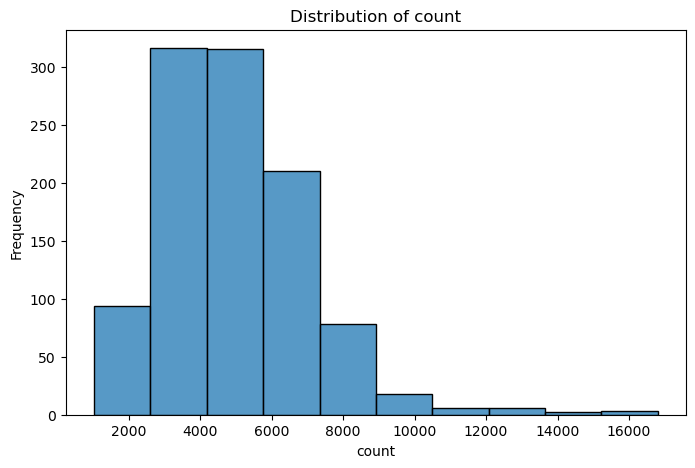

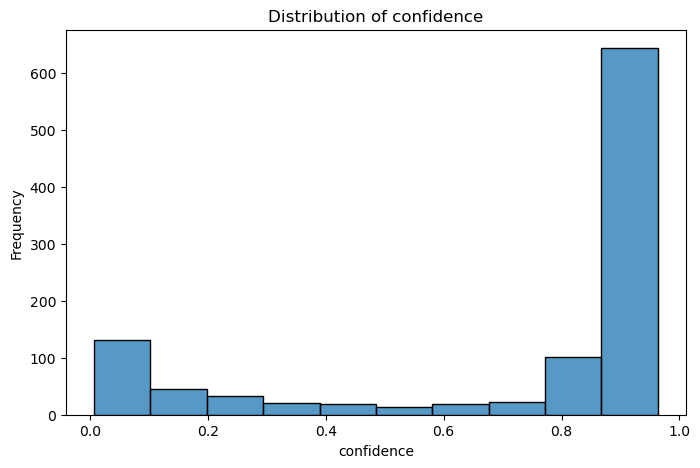

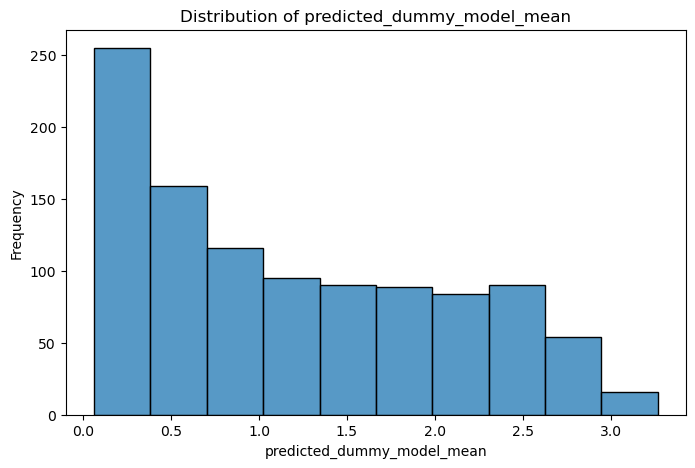

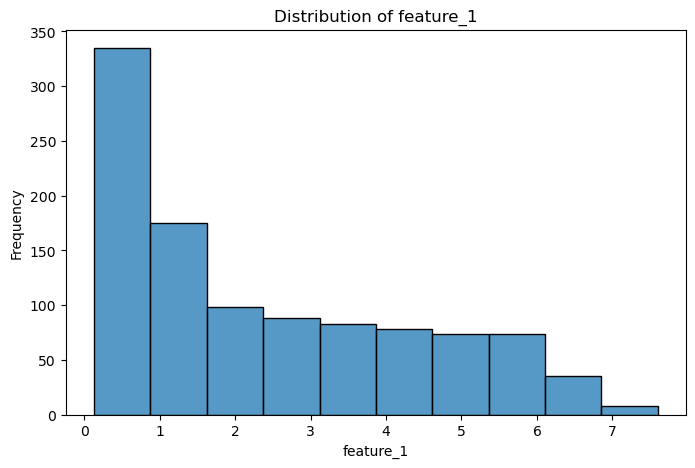

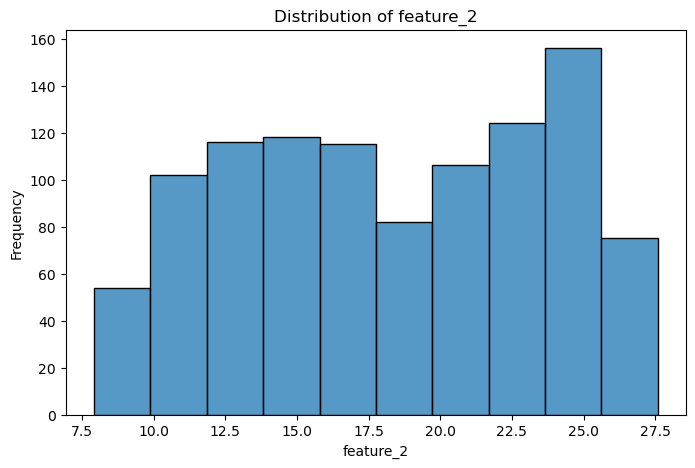

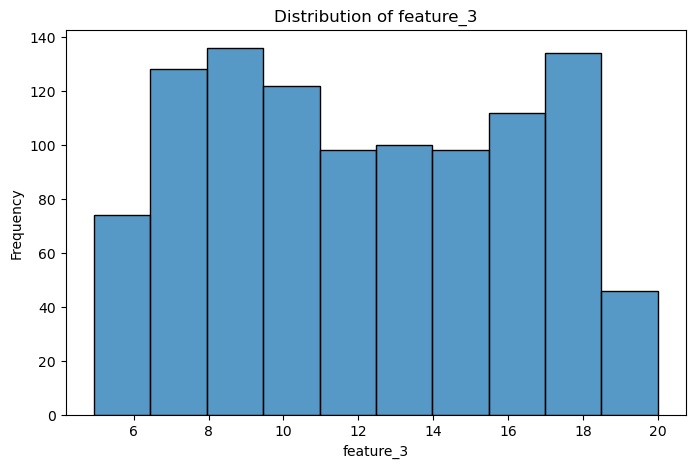

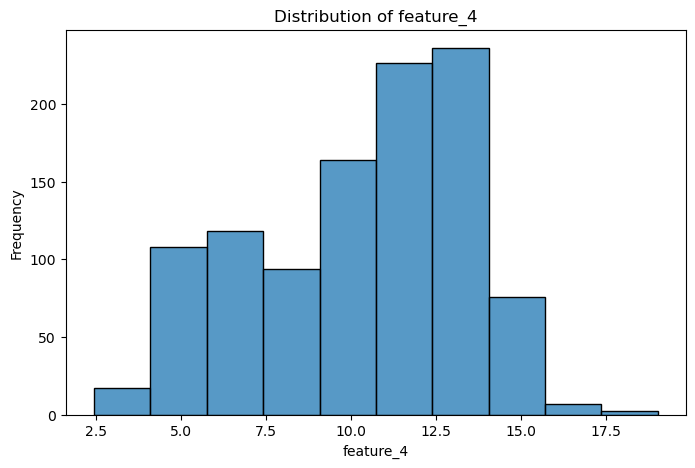

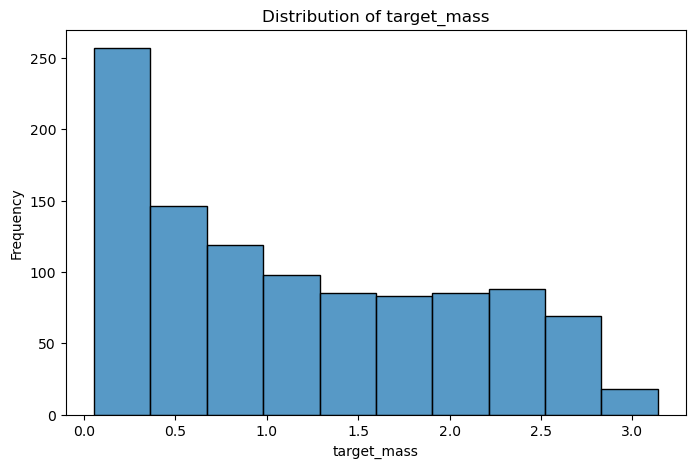

In [20]:
plot_distribution(df, numeric, None, 10)

**Минивывод**  
В разведывательном анализе особо ничего делать не пришлось. 
Пропусков нет  
Дубликатов нет  
Явных выбросов тоже нет  
Написали функции графиков и посмотрели распределения столбцов  
Убрали столбец с именем клиента одного и того же на протяжении всего датасета  

## Исследовательский анализ данных

**Добавим новый столбец**

In [21]:
df['importance'] = 0
df.loc[df['daynum'] >= 35, 'importance'] = 1

In [22]:
df['importance'] = df['importance'].astype('category')

Столбец важности будет показывать сколько у нас птиц старше 34 дней и которые будут являться приоритетом

Глянем на распределение столбцов относительно возраста курочек

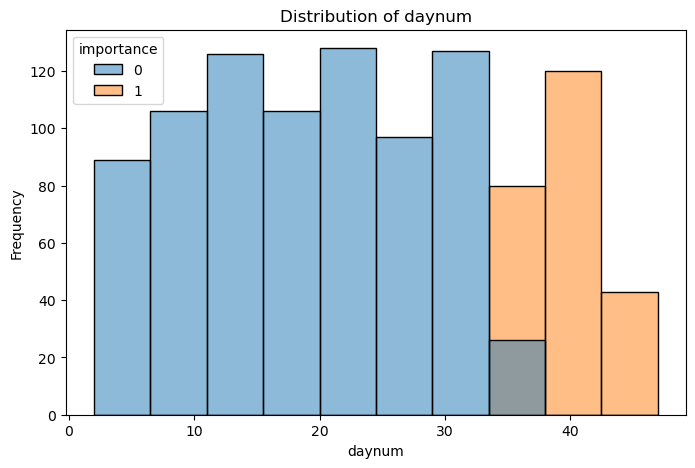

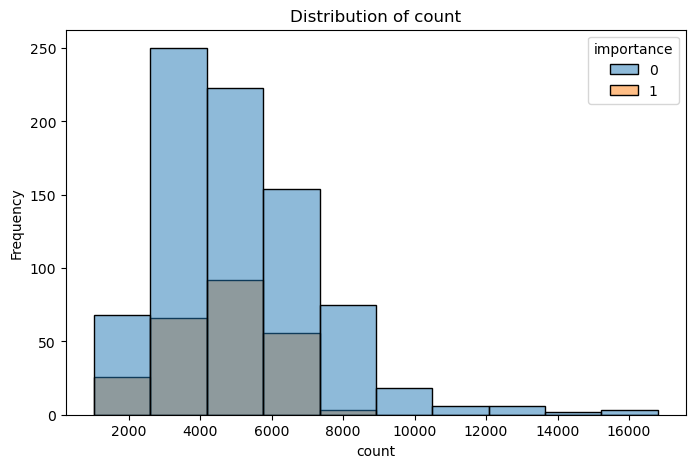

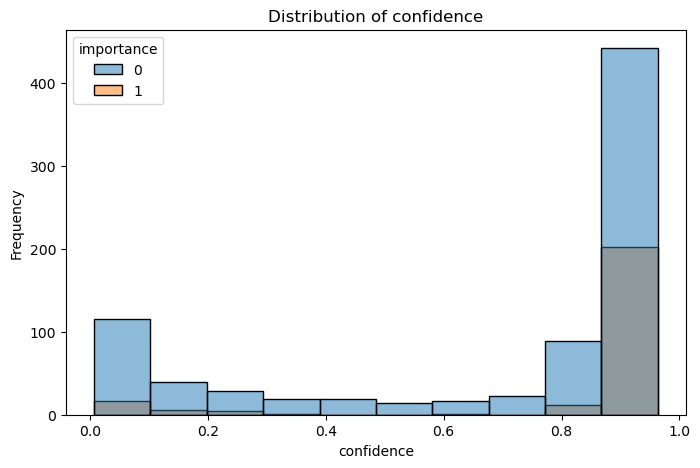

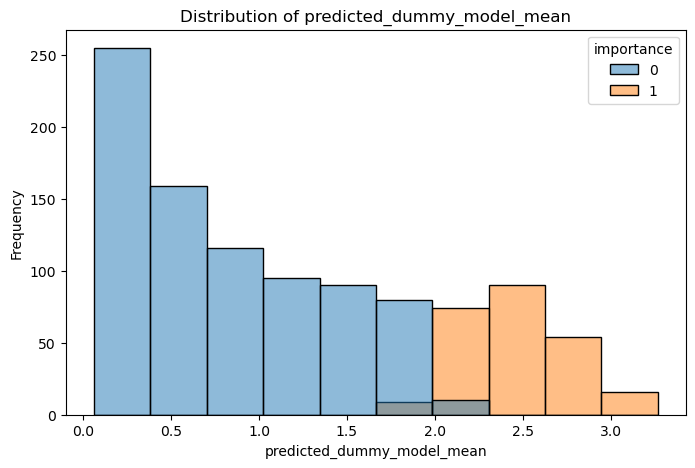

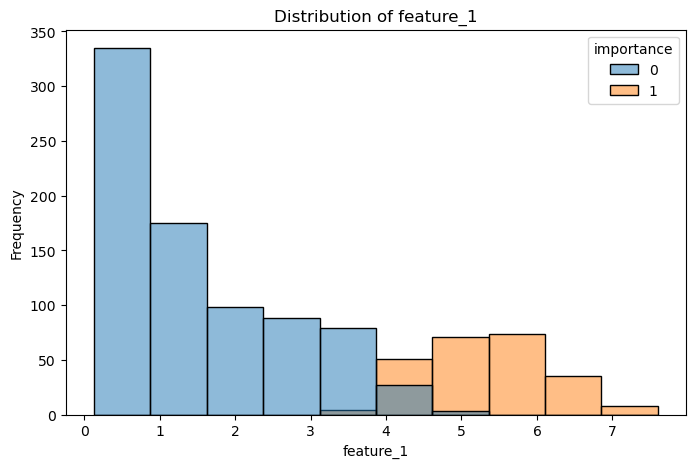

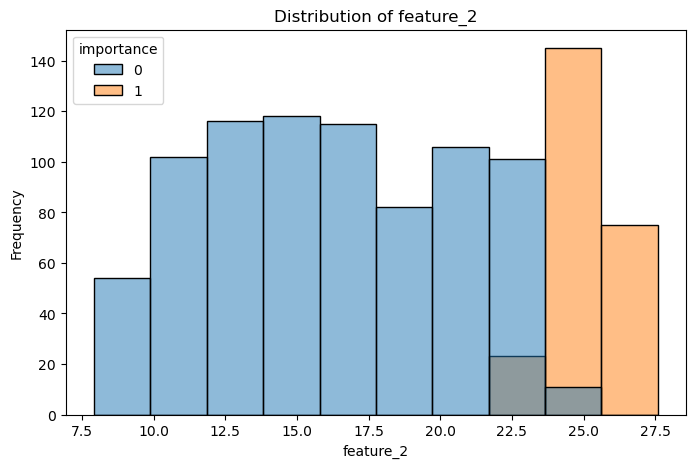

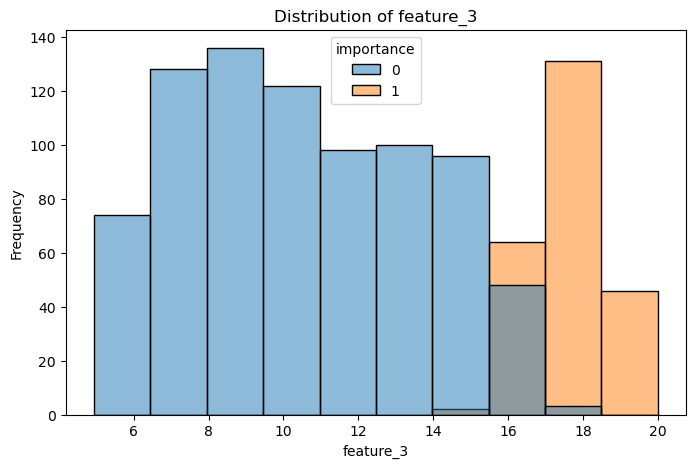

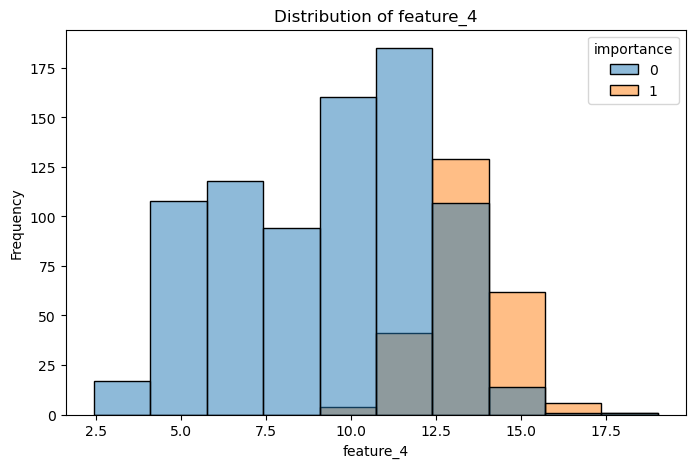

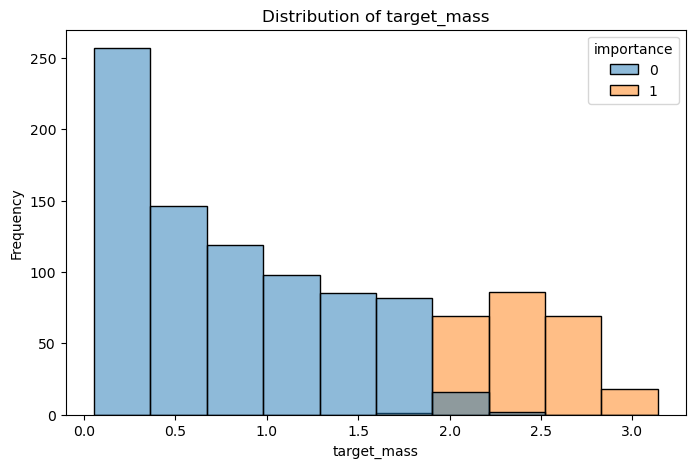

In [24]:
plot_distribution(df, numeric, 'importance', 10)

Если смотреть важность фичей по графикам, то я бы отдал предпочтение фиче №1, так как у неё совпадают распределения с целевой переменной.
Надеялся, что при разделении на hue='importance', я увижу какие-нибудь интересные закономерности, но пока что всё предсказуемо. 
Родилась мысль попробовать обучать отдельно 2 датасета, разделенные по 'importance'

В графике распределения по уверенности модели видно, что модель имеет пик в области 1, что говорит о высокой уверенности в сделанных фото (фичах). Но так же есть небольшой холм в районе 0, что говорит о возможных погрешностях в предсказании веса куриц. Таких значений чуть больше сотни.  
Попробуем задать порог 0.1. Будем экспериментировать при обучении модели таким образом, т.к. увеличивая порог, мы по идее придаём качество нашей модели, но при этом уменьшая датасет и рискуя переобучиться  

In [25]:
threshold = 0.1
df = df.loc[df['confidence'] > threshold]

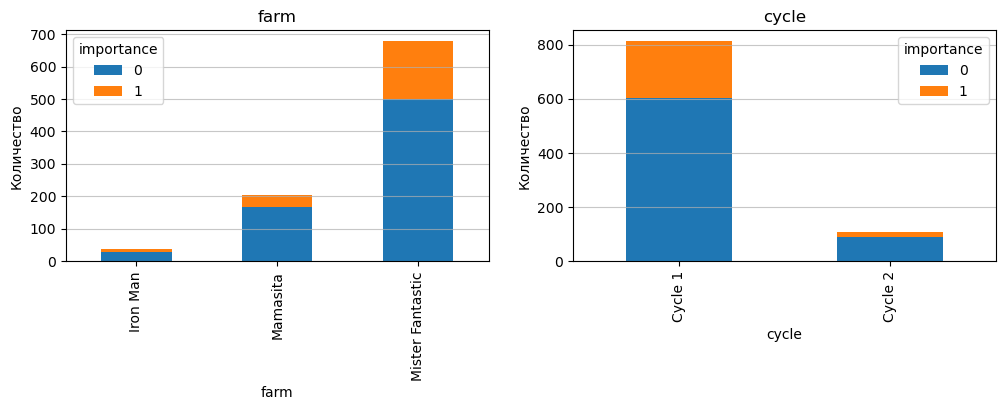

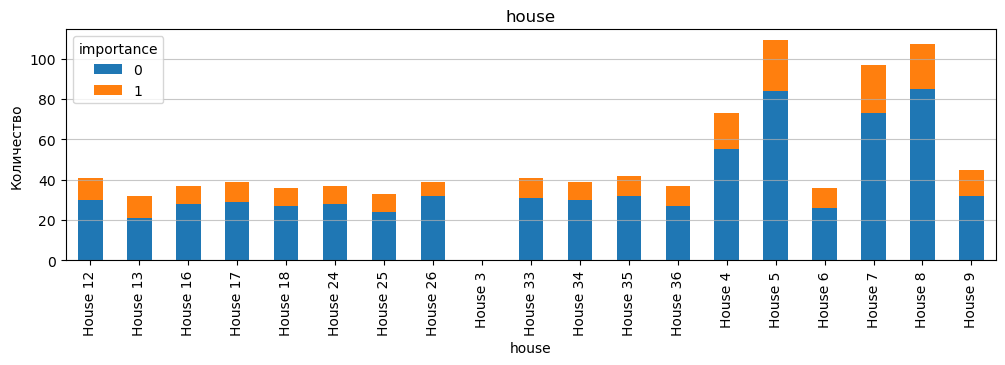

In [26]:
plt.figure(figsize=(12, 3))
cat_bar(df, 121, cat[0], 'importance')
cat_bar(df, 122, cat[2], 'importance')
plt.figure(figsize=(12, 3))
cat_bar(df, 111, cat[1], 'importance')

In [27]:
# Сделаем сводные таблицы, чтобы посмотреть на отношения кол-ва взрослых куриц к цыпляткам

for col in cat:
    table = pd.pivot_table(df, index='importance', values='daynum', columns=col, aggfunc='count')
    table.loc['ratio'] = [table.loc[1, col] / table.loc[0, col] for col in table.columns]
    display(table)

farm,Iron Man,Mamasita,Mister Fantastic
importance,,,
0,29.00,166.00,499.00
1,9.00,38.00,179.00
ratio,0.31,0.23,0.36


house,House 12,House 13,House 16,House 17,House 18,House 24,House 25,House 26,House 3,House 33,House 34,House 35,House 36,House 4,House 5,House 6,House 7,House 8,House 9
importance,,,,,,,,,,,,,,,,,,,
0,30.00,21.00,28.00,29.00,27.00,28.00,24.00,32.00,0.00,31.00,30.00,32.00,27.00,55.00,84.00,26.00,73.00,85.00,32.00
1,11.00,11.00,9.00,10.00,9.00,9.00,9.00,7.00,0.00,10.00,9.00,10.00,10.00,18.00,25.00,10.00,24.00,22.00,13.00
ratio,0.37,0.52,0.32,0.34,0.33,0.32,0.38,0.22,NaN,0.32,0.30,0.31,0.37,0.33,0.30,0.38,0.33,0.26,0.41


cycle,Cycle 1,Cycle 2
importance,,
0,604.00,90.00
1,209.00,17.00
ratio,0.35,0.19


На разных фермах разное отношение взрослых куриц к молодняку. А что если веса куриц отличаются исходя из хозяйства. Например, у Ирона Мана всего 9 взрослых куриц, а на графике зависимости веса от возраста есть небольшое кол-во значений, имеющие небольшие отклонения

In [28]:
pd.pivot_table(df, index='importance', values='target_mass', columns='farm', aggfunc=['median', 'mean'])

median                               mean           \
farm       Iron Man Mamasita Mister Fantastic Iron Man Mamasita   
importance                                                        
0              0.79     0.65             0.77     0.85     0.83   
1              2.39     2.38             2.41     2.40     2.37   

                             
farm       Mister Fantastic  
importance                   
0                      0.85  
1                      2.42

Итак, старшенькие куры примерно находятся в одном диапазоне, но вот вес молодняка у фермеров отличается между собой. Так же средний вес молодняка больше медианного, а у Мамаситы значительно больше медианы, это говорит о том, что есть некоторый молодняк с повышенным весом дающим скошенность вправо.  
Таким образом было решено:
- оставить фермы в обучении как категориальные столбцы
- делать несколько обучений (с разбивкой по importance)

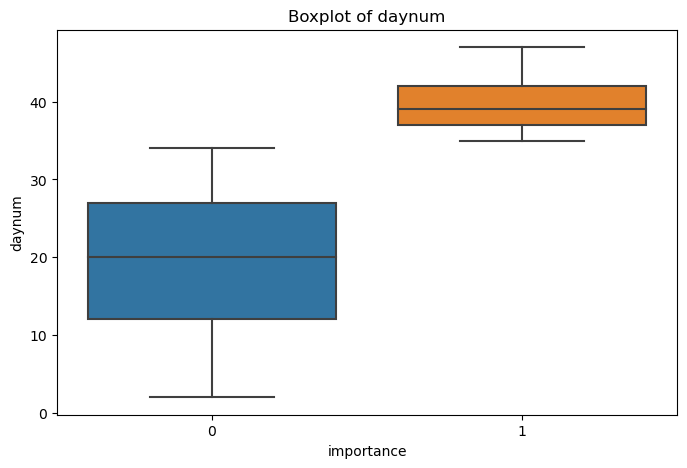

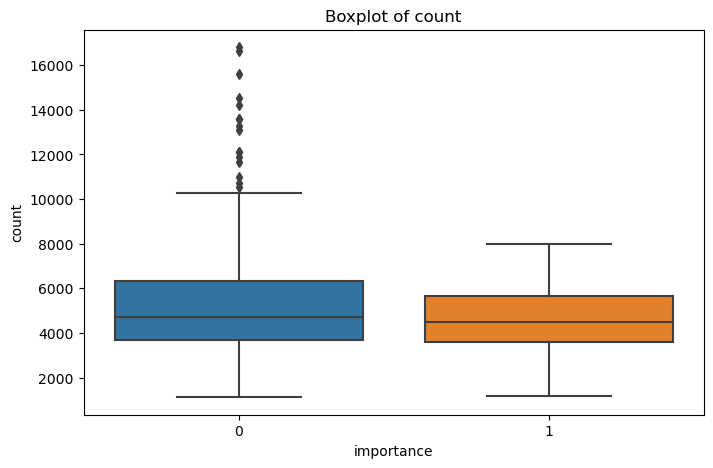

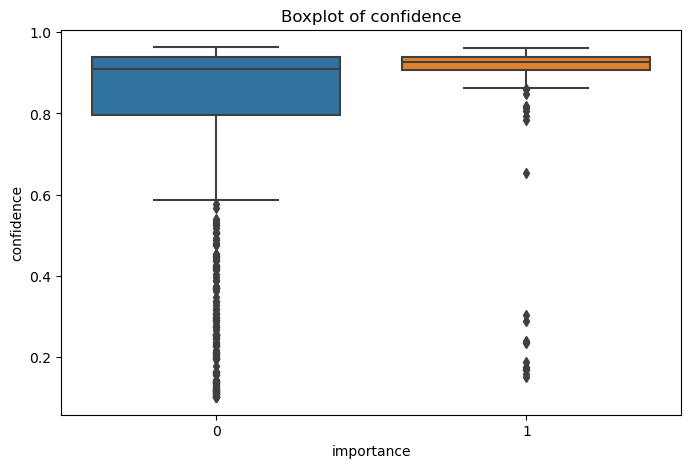

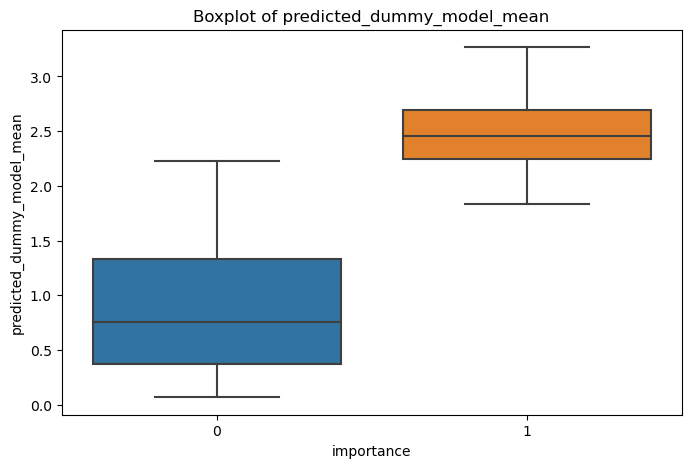

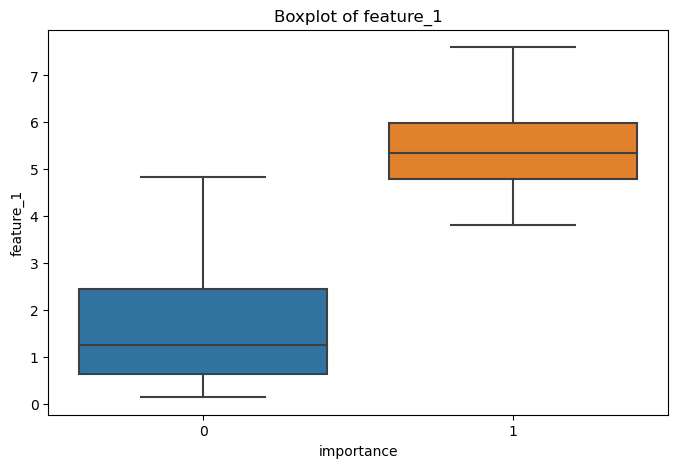

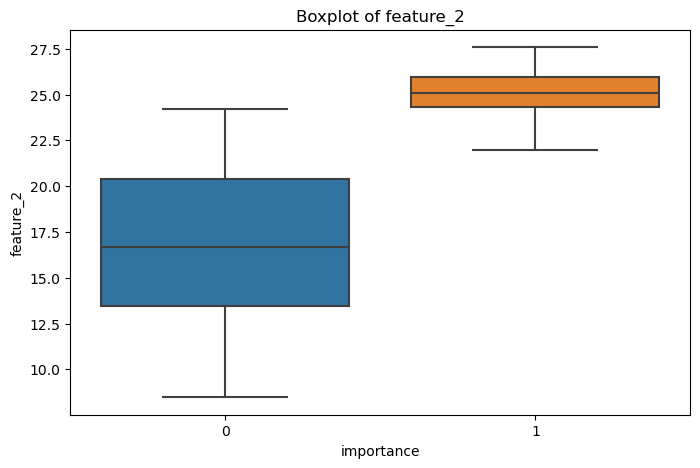

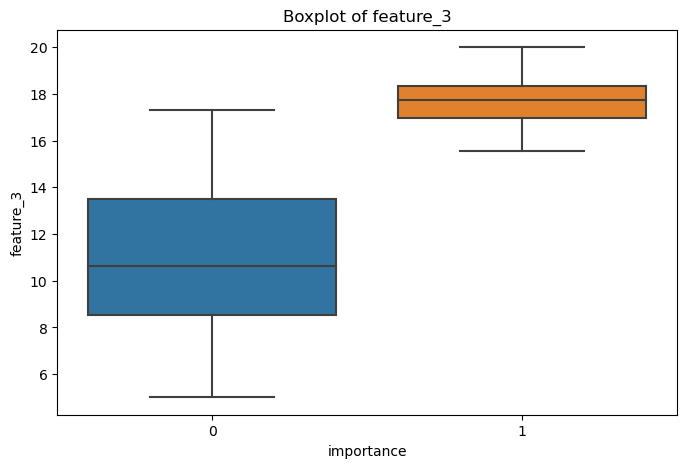

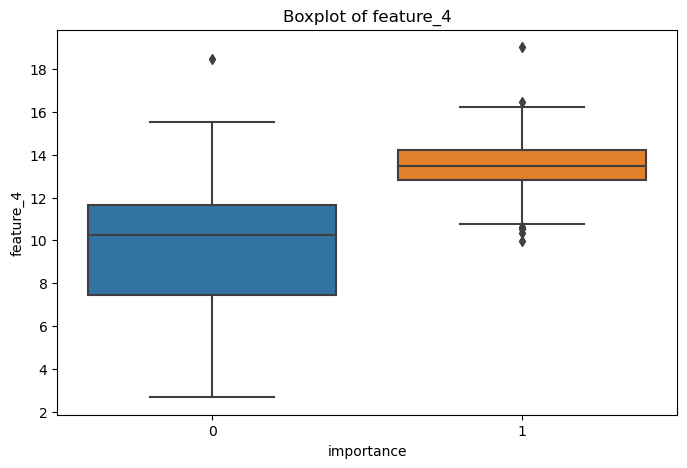

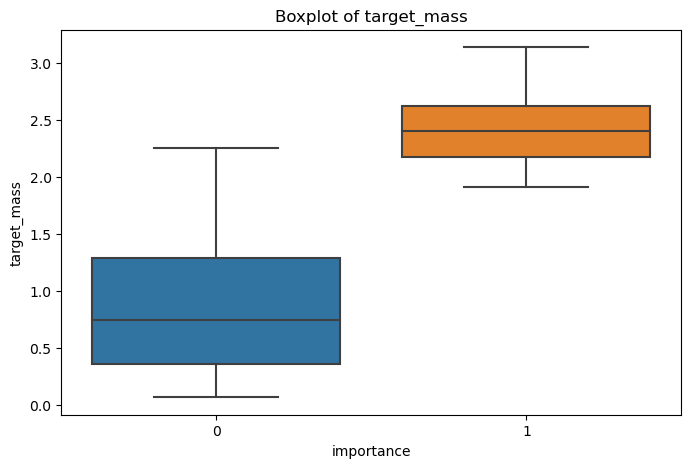

In [29]:
plot_boxplot(df, numeric, 'importance')

Здесь так же заметно сходство распределения первой фичи и таргета  
Пока не буду делать каких-то выводов относительно важности фичей, так как не смотрел корреляции  
Обзор на важность фичей сделаем на одной из обученной модели

### Посмотрим на корреляции между признаками

**тепловая карта числовых признаков**

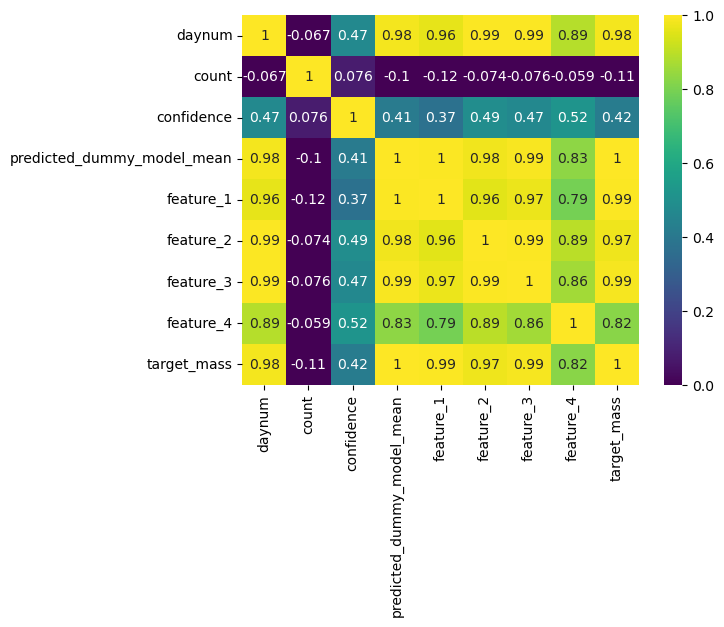

In [30]:
sns.heatmap(df.corr(), cmap='viridis', annot=True, vmin=0);

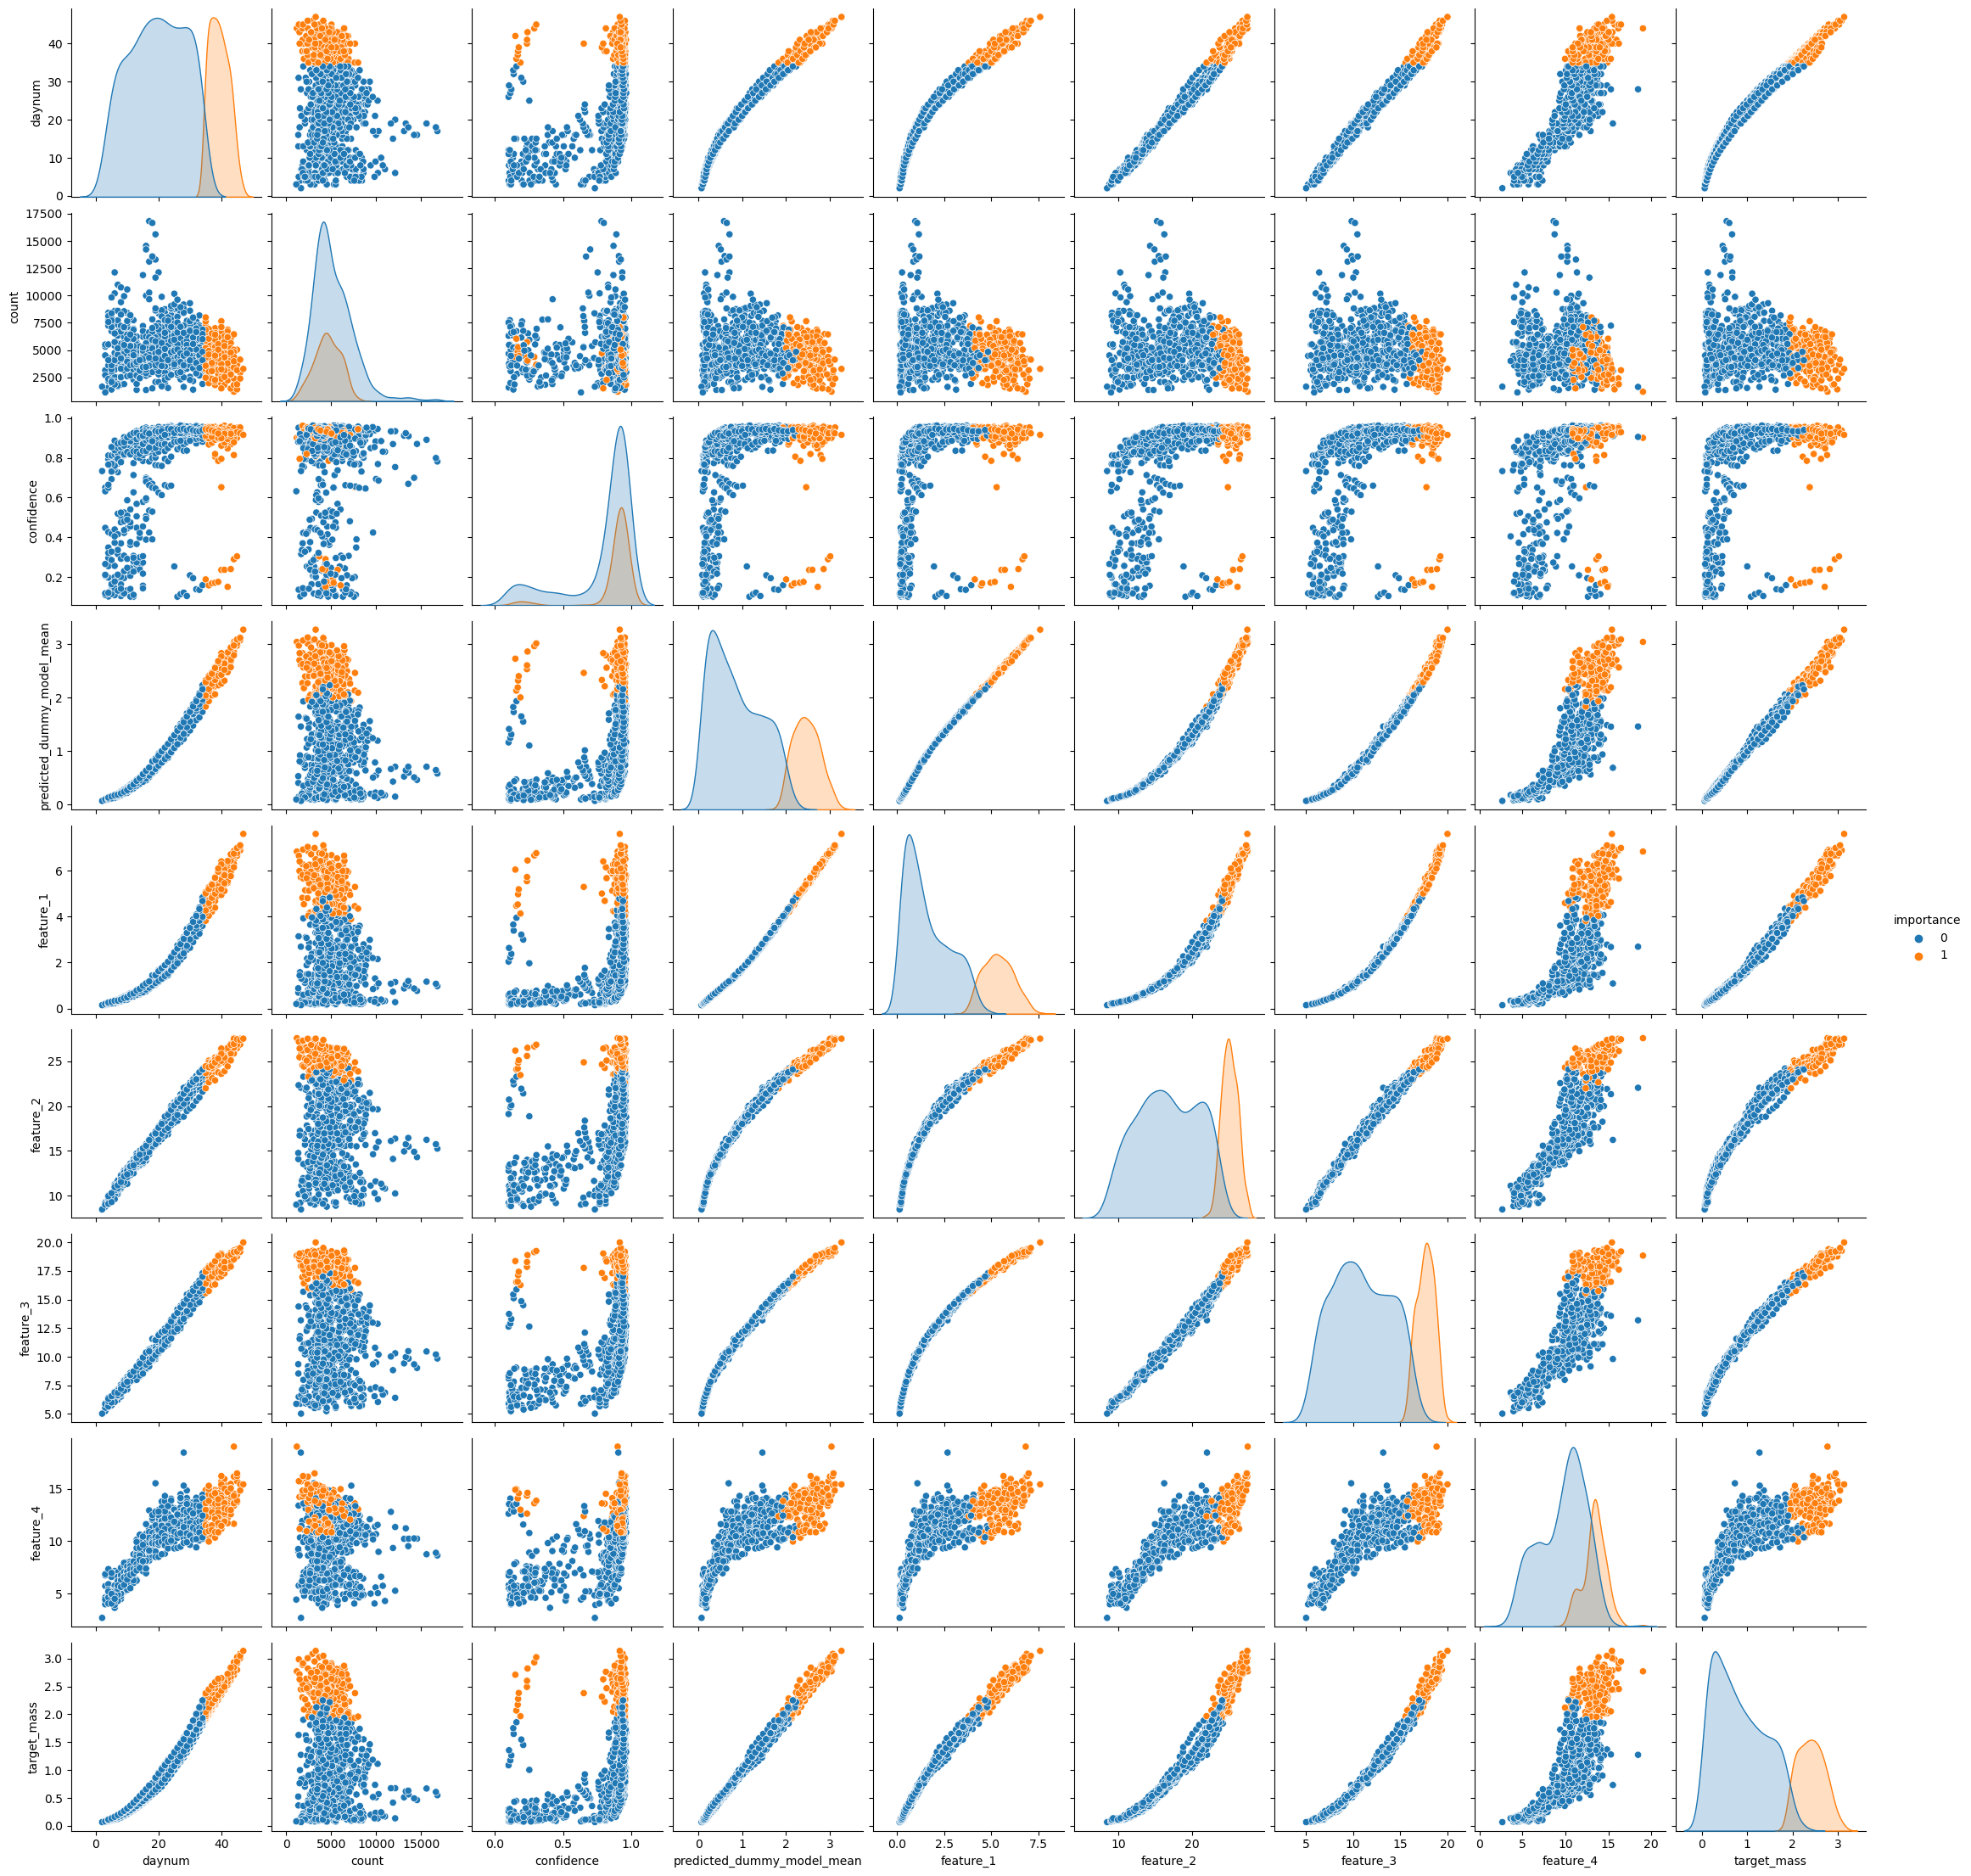

In [31]:
# построим паирплот дополнительно для проверки корреляций

sns.pairplot(df, hue='importance');

Среди числовых столбцов у нас есть высокие корреляции. Учтем это при подготовке датасета для обучения.
И у целового столбца корреляция 0.99 с первой фичей (как и предполагалось из графиков распределений), но так же корреляция 0.99 оказалась и с фичей 3

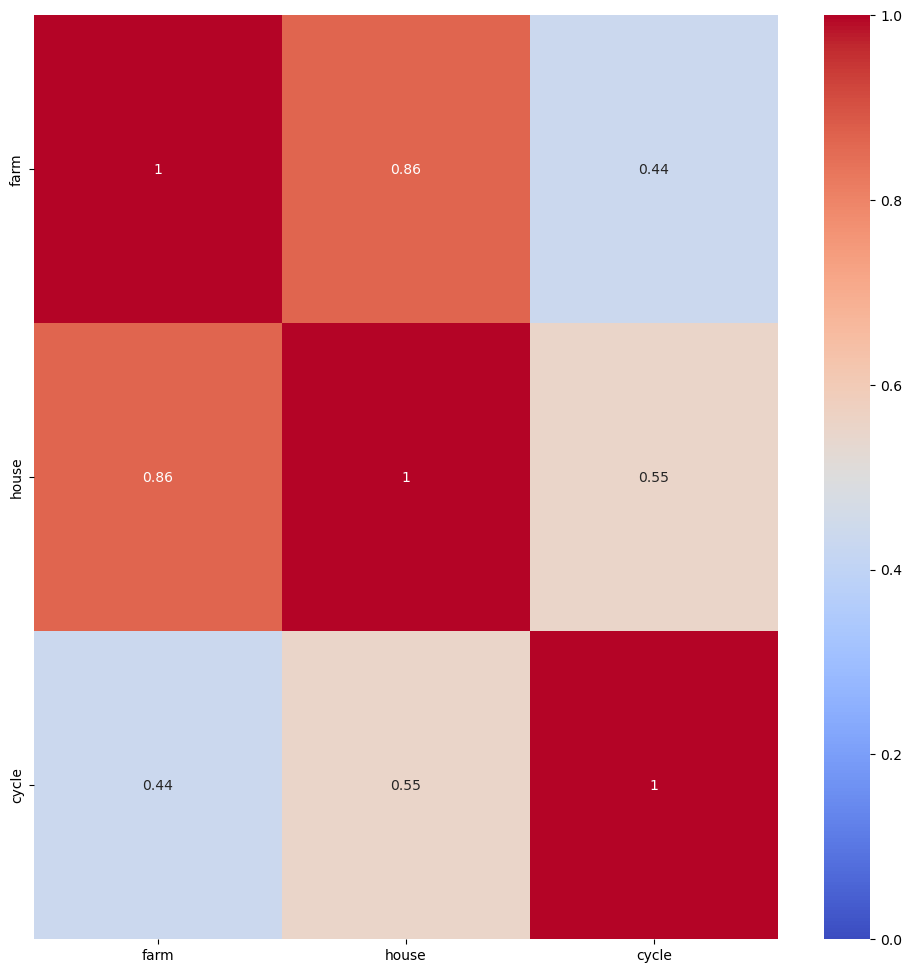

In [32]:
corr_matrix = phik_matrix(df[cat])


fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0, ax=ax)
plt.show()

Этот график - просто формальность, по факту - он не нужен

Паирплот натолкнул на интересную мысль, но для этого увеличим график зависимости возраста от массы

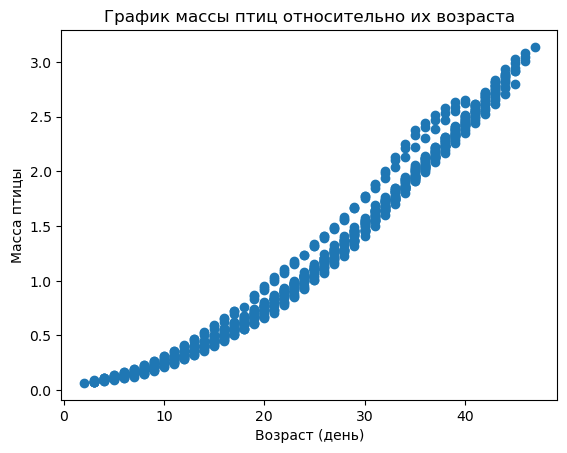

In [33]:
# фильтруем данные по столбцам daynum и target_mass
df_filtered = df[['daynum', 'target_mass']]

# строим scatter plot
plt.scatter(df_filtered['daynum'], df_filtered['target_mass'])
plt.xlabel('Возраст (день)')
plt.ylabel('Масса птицы')
plt.title('График массы птиц относительно их возраста')
plt.show()

График у нас не совсем линейный, поэтому появилась идея разделить возраст птиц на категории

In [34]:
# Попробуем добавить дополительный столбец с категориями возраста птиц

bins = [0, 10, 20, 26, 34, 40, np.inf]
labels = [1, 2, 3, 4, 5, 6]
df['age_category'] = pd.cut(df['daynum'], bins=bins, labels=labels)

**Минивывод:**  
Провели исследовательский анализ данных и предварительно решили, что самыми важными фичами для целевой переменной буду фичи 1 и 3  
Немного обрезали датасет в тех местах, где модель имеет уверенность в верности фотографий ниже заданного порога  
Создали два доп столбца, один показывает старше ли курица 34х дней, а другой разбивает возраст куриц на категории  

## Построение модели

**Разобьём датасет на фичи и таргеты**

In [36]:
# полный датасет
X = df.drop(['house', 'cycle', 'target_mass'], axis=1)
y = df['target_mass']

**Попробуем провести обучение раздельно по данным для больших и малых курочек**

In [37]:
# разделенный датасет
df_1 = df.loc[df['importance'] == 1]
df_0 = df.loc[df['importance'] == 0]

X_1, X_0 = df_1.drop(['house', 'cycle', 'target_mass'], axis=1), df_0.drop(['house', 'cycle', 'target_mass'], axis=1)
y_1, y_0 = df_1['target_mass'], df_0['target_mass']

In [38]:
X.shape, X_1.shape, X_0.shape # X_1.shape = (226, 11), y_1.shape = (226,)

((920, 11), (226, 11), (694, 11))

In [39]:
y.shape, y_1.shape, y_0.shape

((920,), (226,), (694,))

**Разделим фичи и таргеты на тренировочные и тестовые в пропорции 3 к 1**

In [40]:
# полные фичи и таргеты
X, X_test, y, y_test = train_test_split(
                                    X, y, test_size=0.25, random_state=random_state, stratify=df['importance']
)

In [41]:
# разделенные фичи и таргеты
X_1, X_test_1, y_1, y_test_1 = train_test_split(
                                    X_1, y_1, test_size=0.25, random_state=random_state
)
X_0, X_test_0, y_0, y_test_0 = train_test_split(
                                    X_0, y_0, test_size=0.25, random_state=random_state
)

In [42]:
# проверка кол-ва строк и столбцов
X.shape, X_test.shape, y.shape, y_test.shape

((690, 11), (230, 11), (690,), (230,))

In [43]:
# проверка кол-ва строк и столбцов
X_1.shape, X_test_1.shape, y_1.shape, y_test_1.shape

((169, 11), (57, 11), (169,), (57,))

In [44]:
# проверка кол-ва строк и столбцов
X_0.shape, X_test_0.shape, y_0.shape, y_test_0.shape

((520, 11), (174, 11), (520,), (174,))

**Кодировщики**

In [45]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
ohe = OneHotEncoder(drop='first', handle_unknown='ignore')
ss = StandardScaler()

### Создадим словари перебираемых параметров будущих моделей и ансамблей

In [46]:
tree_params = {
    'decisiontreeregressor__max_depth': range(1, 15),
    'decisiontreeregressor__criterion': ['mse', 'friedman_mse', 'mae'],
    'decisiontreeregressor__max_features': ['auto', 'sqrt', 'log2']
}

forest_params = {
    'randomforestregressor__n_estimators' : range(100, 400, 50), 
    'randomforestregressor__max_depth' : range(5, 15, 3),
    'randomforestregressor__min_samples_split' : (2, 3, 4),
    'randomforestregressor__min_samples_leaf' : (1, 2, 3, 4)
}

lgbm_params = {
    'boosting_type': ['gbdt', 'dart', 'goss'], 
    'importance_type': ['split', 'gain'], 
    'learning_rate': [0.1, 0.05, 0.3, 0.01, 0.6], 
    'max_depth': [-1, 3, 5, 6], 
    'n_estimators': [50, 100, 150, 500, 1000],  
    'subsample_for_bin': [200000, 50000, 100000]
}

xgboost_params = {
    'gradientboostingregressor__max_depth' : range(10, 16 , 5), 
    'gradientboostingregressor__learning_rate' : [0.1, 0,3, 0.01],
    'gradientboostingregressor__n_estimators' : range(100, 400, 50)
}

cbr_params ={
             'iterations' : [500, 1000], 
             'depth': [3, 5, 7, 10], 
             'learning_rate': [.1, .01, .001], 
             'l2_leaf_reg': [1, 3, 5, 10], 
             'loss_function': ['MAPE', 'R2']
}

### Напишем функцию рандомсерча

In [47]:
def randomiz_search(model: object, params: dict, num_iter: int, cv: int, X: object, y: object) -> object:
    
    """Функция обучит модель с помощью RandomizedSearchCV
    и вернёт модель, обученную на лучших гиперпараметрах
    с самой высокой метрикой MAPE, а так же напечатает
    значение метрики MAPE и R2"""
        
    model = RandomizedSearchCV(
        model,
        param_distributions = params,
        n_iter = num_iter,
        verbose = 200,
        scoring = ['neg_mean_absolute_percentage_error','r2'],
        cv = cv,
        n_jobs = -1, 
        refit = 'neg_mean_absolute_percentage_error', random_state = random_state
    )
    model.fit(X=X, y=y)
    
    # выведем метрику MAPE на экран
    print("MAPE:", round(abs(model.best_score_), 4))
    
    # выведем метрику R2 на экран
    print("R2:", round(model.cv_results_['mean_test_r2'].mean(), 4))
    
    return model

*Для выбора наилучшей модели можно использовать сразу несколько метрик, например, MAPE и R2, чтобы учесть как абсолютное отклонение, так и процентную ошибку. Также можно отслеживать максимальное отклонение и, при необходимости, уточнять обучающие данные или модель, чтобы улучшить точность предсказаний в циклах-хаусах, где ошибка выше допустимой.*

### Препроцессинг для пайплайна

In [48]:
# создадим списки для числовых значений
numeric = list(X.select_dtypes(include=['int64', 'float64']).columns)
cat = list(X.select_dtypes(include=['category']).columns)

col_transformer_ohe = make_column_transformer(
    (ohe, cat),
    (ss, numeric),
    remainder='passthrough'
)

col_transformer_enc = make_column_transformer(
    (enc, cat),
    (ss, numeric),
    remainder='passthrough'
)

### Пайплайн для линейной регрессии, случайного леса, дерева решений и XGBoost

In [49]:
# линейная регрессия
pipeline_linear = make_pipeline(
    col_transformer_ohe, LinearRegression()
)

# случайный лес
pipeline_forest = make_pipeline(
    col_transformer_enc, RandomForestRegressor(random_state=random_state)
)

# дерево решений
pipeline_tree = make_pipeline(
    col_transformer_enc, DecisionTreeRegressor(random_state=random_state)
)

# XGBoost  
pipeline_xgboost = make_pipeline(
    col_transformer_enc, GradientBoostingRegressor(random_state=random_state)
)

### Пайплайн для решающего дерева с рандомсерчем¶

In [50]:
tree = randomiz_search(pipeline_tree, tree_params, 10, 5, X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
MAPE: 0.0587
R2: nan


### Пайплайн для линейной регрессии с рандомсерчем

In [51]:
regression = randomiz_search(pipeline_linear, {}, 10, 5, X, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
MAPE: 0.0517
R2: 0.9967


### Пайплайн для случайного леса с рандомсерчем

In [52]:
forest = randomiz_search(pipeline_forest, forest_params, 10, 5, X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
MAPE: 0.0436
R2: 0.9954


### LGBMRegressor

In [53]:
model_lgbm = randomiz_search(
    LGBMRegressor(
                random_state = random_state
                 ), 
    lgbm_params, 10, 5, X, y
    )

Fitting 5 folds for each of 10 candidates, totalling 50 fits
MAPE: 0.0452
R2: 0.9881


### XGBoost

In [54]:
model_xgboost = randomiz_search(pipeline_xgboost, xgboost_params, 10, 5, X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
MAPE: 0.0517
R2: -4.18718797807108e+179


### CatBoostRegressor

In [55]:
model_cbc = randomiz_search(
    CatBoostRegressor(
        cat_features=cat,
        random_seed = random_state
            ), 
    cbr_params, 10, 5, X, y
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 0.4568346	total: 159ms	remaining: 2m 39s
1:	learn: 0.4523320	total: 172ms	remaining: 1m 25s
2:	learn: 0.4478246	total: 186ms	remaining: 1m 1s
3:	learn: 0.4433900	total: 197ms	remaining: 49s
4:	learn: 0.4389096	total: 221ms	remaining: 44s
5:	learn: 0.4343930	total: 237ms	remaining: 39.2s
6:	learn: 0.4297105	total: 257ms	remaining: 36.4s
7:	learn: 0.4252732	total: 282ms	remaining: 35s
8:	learn: 0.4211112	total: 298ms	remaining: 32.8s
9:	learn: 0.4168052	total: 316ms	remaining: 31.3s
10:	learn: 0.4125936	total: 328ms	remaining: 29.4s
11:	learn: 0.4084204	total: 340ms	remaining: 28s
12:	learn: 0.4041644	total: 351ms	remaining: 26.7s
13:	learn: 0.4000251	total: 374ms	remaining: 26.4s
14:	learn: 0.3961260	total: 408ms	remaining: 26.8s
15:	learn: 0.3922905	total: 422ms	remaining: 26s
16:	learn: 0.3881993	total: 450ms	remaining: 26s
17:	learn: 0.3845044	total: 466ms	remaining: 25.4s
18:	learn: 0.3805956	total: 479ms	remaini

**Лучшей моделью у нас оказался ансамблевый бэггинг - случайный лес и отечественный катбуст)**

### Построим график важности признаков

Для случайного леса

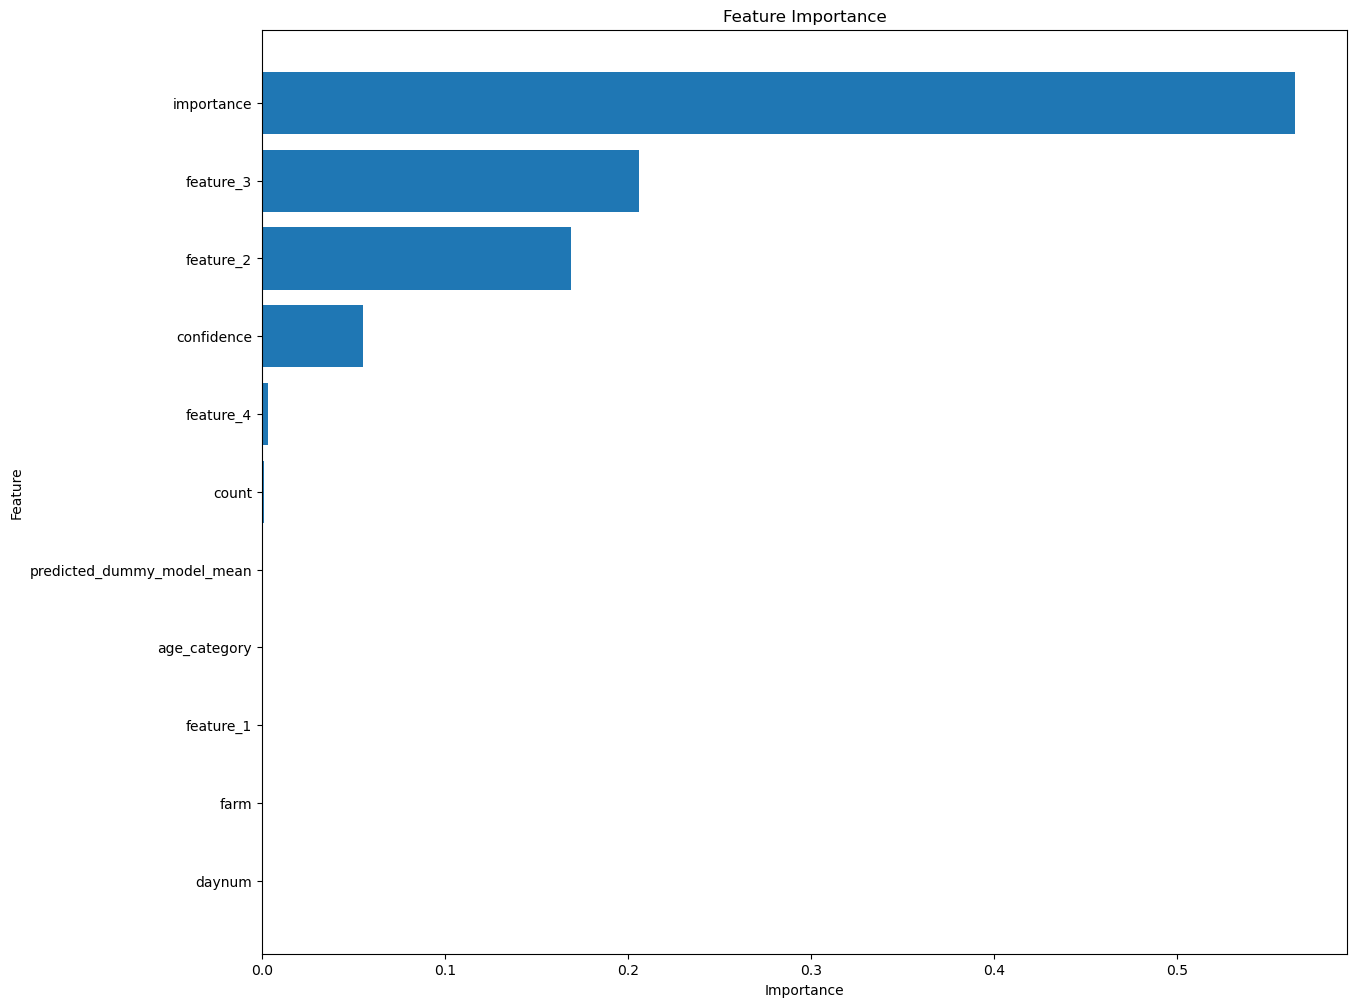

In [56]:
fig, ax = plt.subplots(figsize=(14, 12))
# получение модели леса из пайплайна
forest_model = forest.best_estimator_.named_steps['randomforestregressor']

# получение важности признаков
importance = forest_model.feature_importances_

# создание датафрейма с важностью признаков
importance_df = pd.DataFrame({'feature': X.columns, 'importance': importance})

# сортировка признаков по важности
importance_df = importance_df.sort_values('importance')

# построение графика важности признаков
plt.barh(importance_df['feature'], importance_df['importance'])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Для катбуста

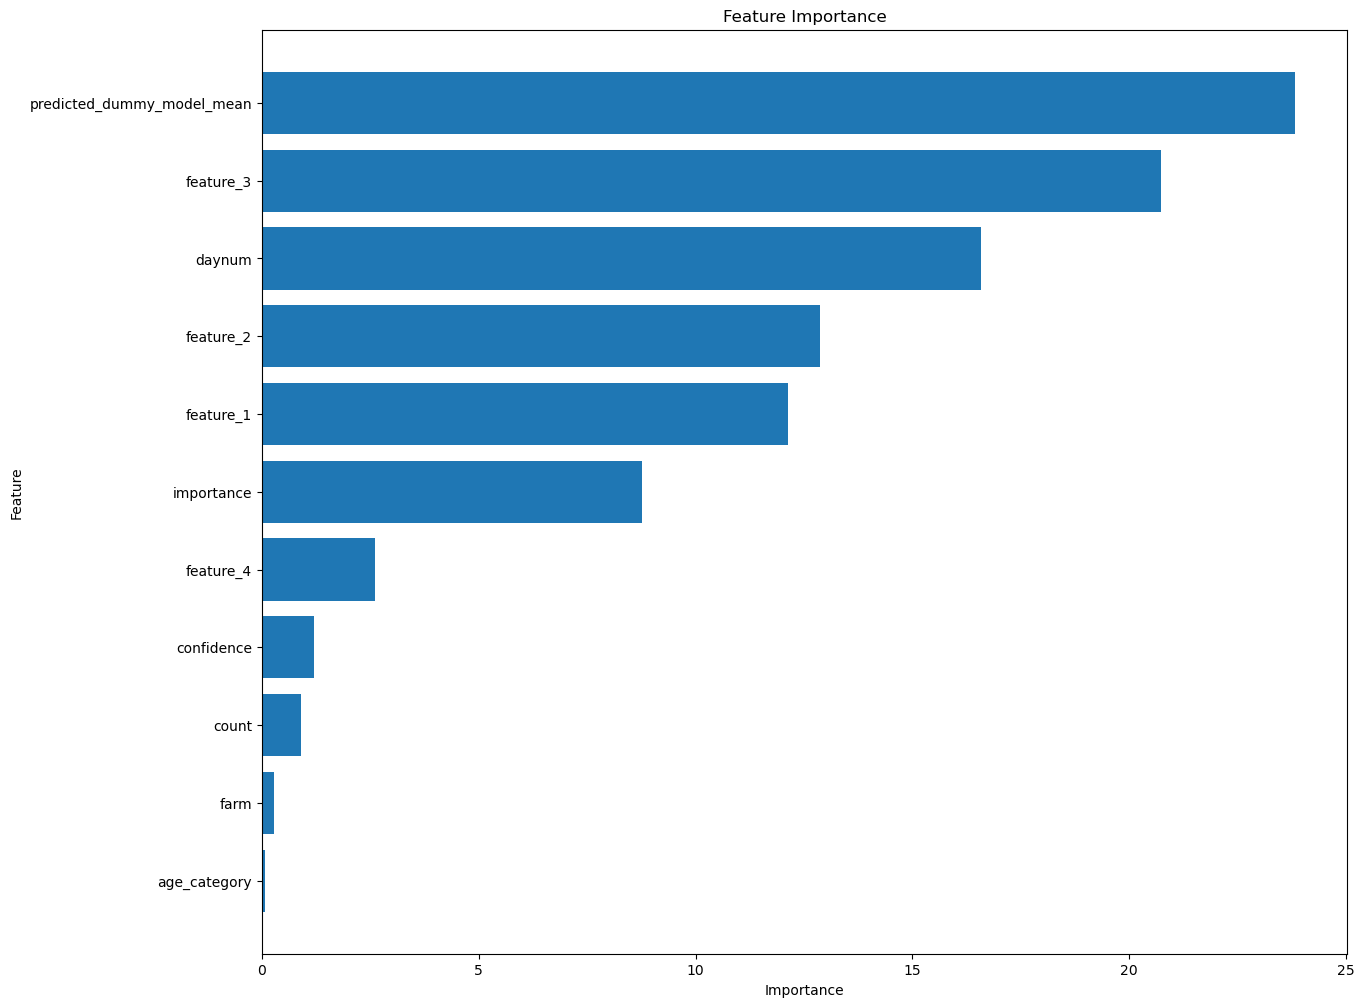

In [57]:
fig, ax = plt.subplots(figsize=(14, 12))
# получение модели леса из пайплайна
model = model_cbc.best_estimator_

# получение важности признаков
importance = model.feature_importances_

# создание датафрейма с важностью признаков
importance_df = pd.DataFrame({'feature': X.columns, 'importance': importance})

# сортировка признаков по важности
importance_df = importance_df.sort_values('importance')

# построение графика важности признаков
plt.barh(importance_df['feature'], importance_df['importance'])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Как видим из двух графиков лучших моделей лучшей из фичей оказалась под номером 3 (не считая сгенерированных)
Столбец с категорией возраста оказался не нужен, но стоило попытаться

## Обучение для разбитого датасета

### Пайплайн для решающего дерева с рандомсерчем¶

In [58]:
tree_1 = randomiz_search(pipeline_tree, tree_params, 10, 5, X_1, y_1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
MAPE: 0.0324
R2: nan


In [59]:
tree_0 = randomiz_search(pipeline_tree, tree_params, 10, 5, X_0, y_0)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
MAPE: 0.0668
R2: nan


### Пайплайн для линейной регрессии с рандомсерчем

In [60]:
regression_1 = randomiz_search(pipeline_linear, {}, 10, 5, X_1, y_1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
MAPE: 0.0206
R2: 0.9443


In [61]:
regression_0 = randomiz_search(pipeline_linear, {}, 10, 5, X_0, y_0)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
MAPE: 0.0572
R2: 0.9949


### Пайплайн для случайного леса с рандомсерчем

In [62]:
forest_1 = randomiz_search(pipeline_forest, forest_params, 10, 5, X_1, y_1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
MAPE: 0.0225
R2: 0.9287


In [63]:
forest_0 = randomiz_search(pipeline_forest, forest_params, 10, 5, X_0, y_0)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
MAPE: 0.0491
R2: 0.9923


### LGBMRegressor

In [64]:
model_lgbm_1 = randomiz_search(
    LGBMRegressor(
                random_state = random_state
                 ), 
    lgbm_params, 10, 5, X_1, y_1
    )

Fitting 5 folds for each of 10 candidates, totalling 50 fits
MAPE: 0.026
R2: 0.8524


In [65]:
model_lgbm_0 = randomiz_search(
    LGBMRegressor(
                random_state = random_state
                 ), 
    lgbm_params, 10, 5, X_0, y_0
    )

Fitting 5 folds for each of 10 candidates, totalling 50 fits
MAPE: 0.0485
R2: 0.9847


### XGBoost

In [66]:
model_xgboost_1 = randomiz_search(pipeline_xgboost, xgboost_params, 10, 5, X_1, y_1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
MAPE: 0.0254
R2: -4.6238730424561427e+179


In [67]:
model_xgboost_0 = randomiz_search(pipeline_xgboost, xgboost_params, 10, 5, X_0, y_0)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
MAPE: 0.0603
R2: -4.207060473789898e+179


### CatBoostRegressor

In [68]:
model_cbc_1 = randomiz_search(
    CatBoostRegressor(
        cat_features=cat,
        random_seed = random_state
            ), 
    cbr_params, 10, 5, X_1, y_1
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 0.0916709	total: 26.9ms	remaining: 26.9s
1:	learn: 0.0832181	total: 54.5ms	remaining: 27.2s
2:	learn: 0.0759388	total: 78.3ms	remaining: 26s
3:	learn: 0.0693503	total: 110ms	remaining: 27.3s
4:	learn: 0.0636176	total: 129ms	remaining: 25.6s
5:	learn: 0.0579516	total: 159ms	remaining: 26.3s
6:	learn: 0.0534487	total: 175ms	remaining: 24.8s
7:	learn: 0.0497930	total: 215ms	remaining: 26.6s
8:	learn: 0.0460095	total: 250ms	remaining: 27.6s
9:	learn: 0.0425197	total: 294ms	remaining: 29.1s
10:	learn: 0.0397680	total: 319ms	remaining: 28.7s
11:	learn: 0.0376621	total: 343ms	remaining: 28.3s
12:	learn: 0.0350804	total: 384ms	remaining: 29.2s
13:	learn: 0.0329692	total: 420ms	remaining: 29.6s
14:	learn: 0.0309175	total: 467ms	remaining: 30.6s
15:	learn: 0.0295574	total: 493ms	remaining: 30.3s
16:	learn: 0.0282903	total: 537ms	remaining: 31.1s
17:	learn: 0.0275879	total: 555ms	remaining: 30.3s
18:	learn: 0.0262291	total: 61

In [69]:
model_cbc_0 = randomiz_search(
    CatBoostRegressor(
        cat_features=cat,
        random_seed = random_state
            ), 
    cbr_params, 10, 5, X_0, y_0
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 0.3652098	total: 13.9ms	remaining: 13.9s
1:	learn: 0.3616323	total: 24.3ms	remaining: 12.2s
2:	learn: 0.3580220	total: 54.4ms	remaining: 18.1s
3:	learn: 0.3546015	total: 66.9ms	remaining: 16.7s
4:	learn: 0.3510180	total: 93.3ms	remaining: 18.6s
5:	learn: 0.3474615	total: 124ms	remaining: 20.5s
6:	learn: 0.3439847	total: 138ms	remaining: 19.6s
7:	learn: 0.3404668	total: 152ms	remaining: 18.9s
8:	learn: 0.3370521	total: 173ms	remaining: 19s
9:	learn: 0.3336946	total: 190ms	remaining: 18.8s
10:	learn: 0.3303457	total: 199ms	remaining: 17.9s
11:	learn: 0.3269792	total: 216ms	remaining: 17.8s
12:	learn: 0.3235213	total: 236ms	remaining: 17.9s
13:	learn: 0.3202873	total: 254ms	remaining: 17.9s
14:	learn: 0.3171319	total: 270ms	remaining: 17.7s
15:	learn: 0.3139063	total: 287ms	remaining: 17.7s
16:	learn: 0.3108548	total: 302ms	remaining: 17.4s
17:	learn: 0.3077139	total: 315ms	remaining: 17.2s
18:	learn: 0.3045670	total: 

В разбитой выборке лучшим ансамблем оказался случайный лес.   
Построим для него график важности фичей

**График важности для больших курочек**

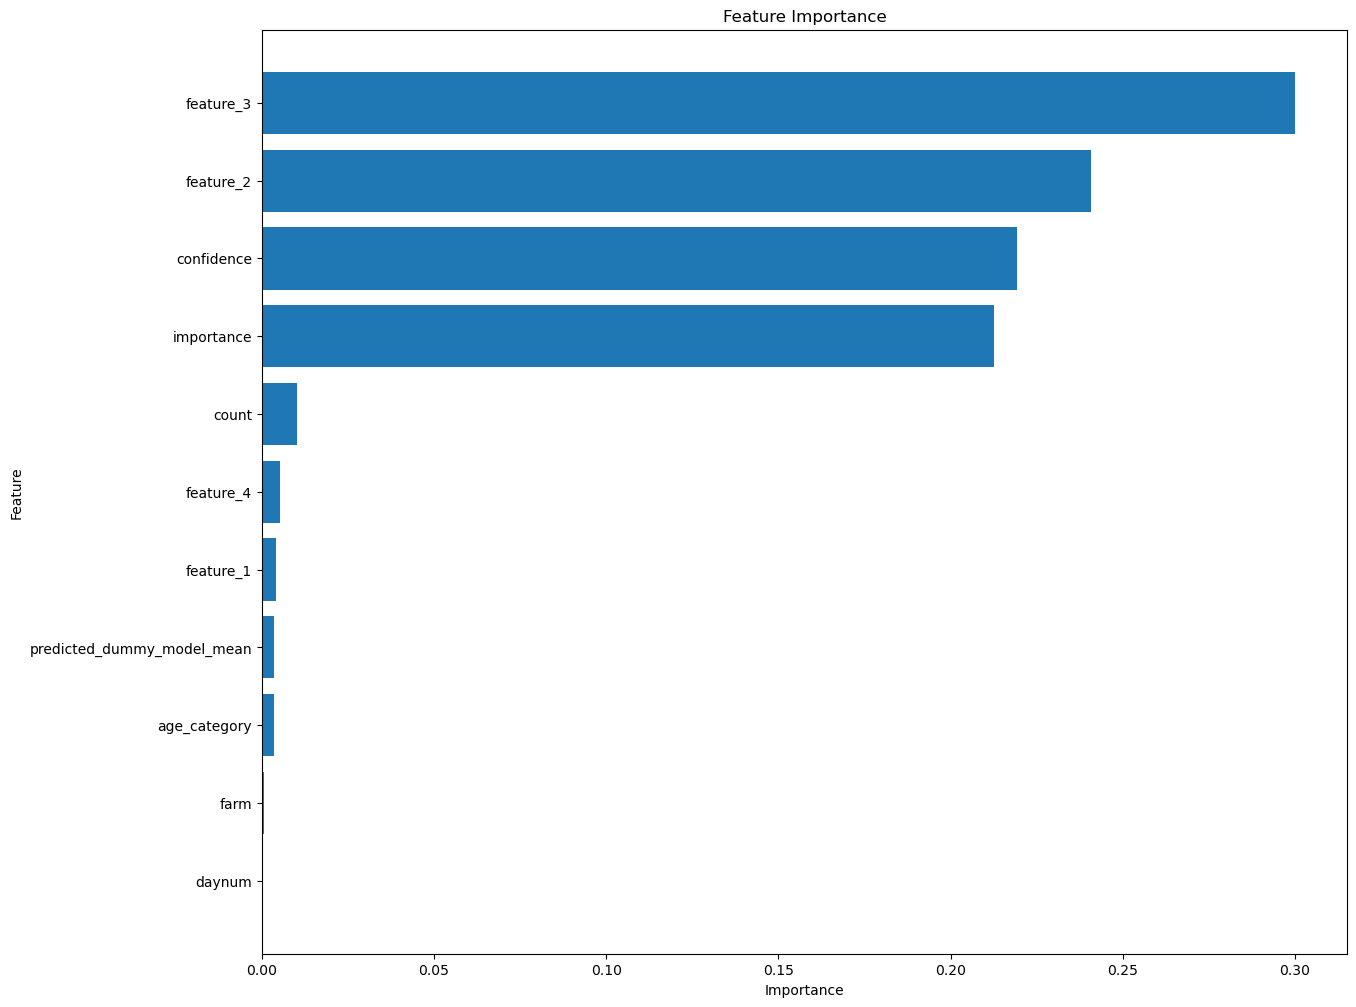

In [70]:
fig, ax = plt.subplots(figsize=(14, 12))
# получение модели леса из пайплайна
forest_model = forest_1.best_estimator_.named_steps['randomforestregressor']

# получение важности признаков
importance = forest_model.feature_importances_

# создание датафрейма с важностью признаков
importance_df = pd.DataFrame({'feature': X.columns, 'importance': importance})

# сортировка признаков по важности
importance_df = importance_df.sort_values('importance')

# построение графика важности признаков
plt.barh(importance_df['feature'], importance_df['importance'])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

**График важности для молодняка**

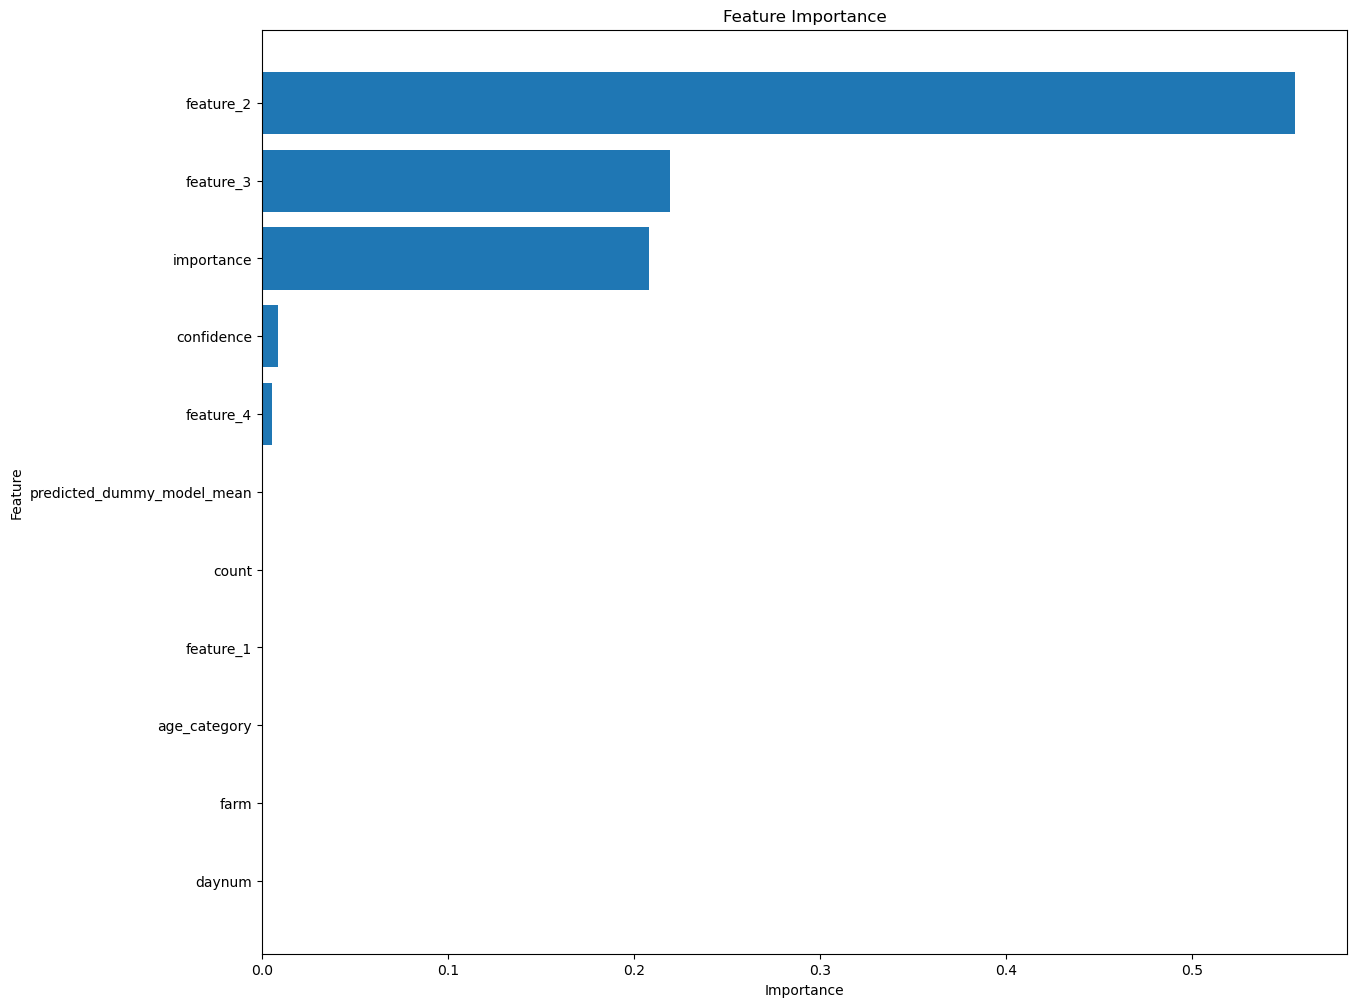

In [71]:
fig, ax = plt.subplots(figsize=(14, 12))
# получение модели леса из пайплайна
forest_model = forest_0.best_estimator_.named_steps['randomforestregressor']

# получение важности признаков
importance = forest_model.feature_importances_

# создание датафрейма с важностью признаков
importance_df = pd.DataFrame({'feature': X.columns, 'importance': importance})

# сортировка признаков по важности
importance_df = importance_df.sort_values('importance')

# построение графика важности признаков
plt.barh(importance_df['feature'], importance_df['importance'])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Посмотрев на графики важности, можно сделать вывод, что под разный возраст подходят разные фичи для определения веса

## Предикты

### Предикт для общего датасета

In [72]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Вычисляет среднюю абсолютную процентную ошибку."""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [73]:
# получим предсказания модели на тестовой выборке
y_pred = forest.best_estimator_.predict(X_test)

# вычислим метрику MAPE на тестовой выборке
mape = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE на тестовой выборке:", round(mape, 4))

# вычислим метрику R2 на тестовой выборке
r2 = r2_score(y_test, y_pred)
print("R2 на тестовой выборке:", round(r2, 4))

MAPE на тестовой выборке: 3.9699
R2 на тестовой выборке: 0.9961


In [74]:
# сохраним нашу погрешность на тестовой выборке в процентах
threshold = mape

### Предикты для разбитого датасета

In [75]:
# получим предсказания модели на тестовой выборке
y_pred = forest_1.best_estimator_.predict(X_test)

# вычислим метрику MAPE на тестовой выборке
mape = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE на тестовой выборке:", round(mape, 4))

# вычислим метрику R2 на тестовой выборке
r2 = r2_score(y_test, y_pred)
print("R2 на тестовой выборке:", round(r2, 4))

MAPE на тестовой выборке: 294.9208
R2 на тестовой выборке: -0.9283


In [76]:
# получим предсказания модели на тестовой выборке
y_pred = forest_0.best_estimator_.predict(X_test)

# вычислим метрику MAPE на тестовой выборке
mape = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE на тестовой выборке:", round(mape, 4))

# вычислим метрику R2 на тестовой выборке
r2 = r2_score(y_test, y_pred)
print("R2 на тестовой выборке:", round(r2, 4))

MAPE на тестовой выборке: 3.9926
R2 на тестовой выборке: 0.9556


Тестовая выборка была завалена для старших курочек, модель прогнозирует их хуже чем случайным образом  
Значит, с большими курочками что-то не так, проведём расследование))

## Расследование

In [77]:
# создаем датасет из y_test и y_pred и вспомогательных столбцов
dataset = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 'daynum': X_test['daynum'], 'importance':X_test['importance']})
# добавим столбец mape для каждой строки
dataset['mape'] = np.abs((dataset['y_test'] - dataset['y_pred']) / dataset['y_test']) * 100

In [78]:
dataset.sample(10)

,y_test,y_pred,daynum,importance,mape
192,1.83,1.84,33,0,0.79
937,2.27,2.16,38,1,4.85
890,0.77,0.75,20,0,2.33
62,0.86,0.85,22,0,1.13
672,1.13,1.13,26,0,0.27
514,1.92,1.87,34,0,2.17
460,0.84,0.83,21,0,0.99
334,0.40,0.42,13,0,4.38
3,0.10,0.10,5,0,4.69
427,1.11,1.15,25,0,3.68


Построим графики распределения для 'y_test', 'y_pred' относительно 'importance'

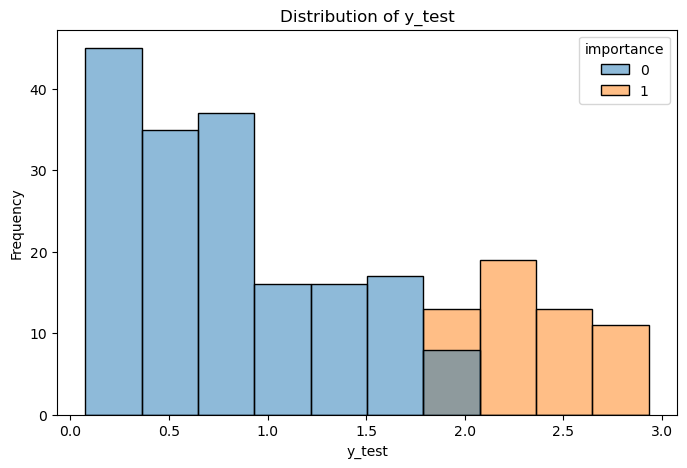

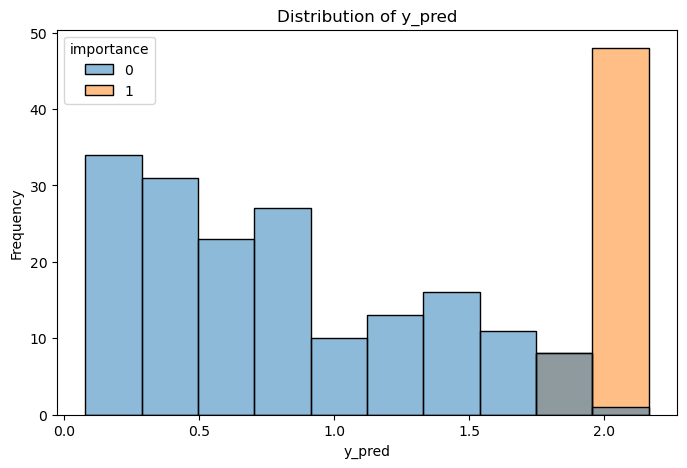

In [79]:
plot_distribution(dataset, dataset[['y_test', 'y_pred']], 'importance', 10)

Графики отлично показывают, что наша модель "недовешивает" больших курочек, следовательно смотреть надо по большим курочкам  
Рассмотрим два варианта:

In [80]:
# соберем список индексов, где порог метрики mape превышен в 5 раз
list_1 = dataset[dataset['mape'] > (threshold * 5)].index.to_list()
# посмотрим на общем датасете, будет ли выделяться явный фермер и цикл
df.loc[list_1]

,farm,house,cycle,daynum,count,confidence,predicted_dummy_model_mean,feature_1,feature_2,feature_3,feature_4,target_mass,importance,age_category
42,Mister Fantastic,House 12,Cycle 1,45,4177,0.93,3.04,6.92,26.80,19.40,14.44,2.80,1,6
647,Mister Fantastic,House 7,Cycle 1,44,4370,0.29,2.96,6.67,26.66,19.14,13.62,2.93,1,6
445,Mister Fantastic,House 35,Cycle 1,43,5647,0.92,2.88,6.54,26.46,19.09,13.90,2.76,1,6
646,Mister Fantastic,House 7,Cycle 1,43,4029,0.24,2.86,6.44,26.51,18.89,14.62,2.82,1,6
813,Iron Man,House 4,Cycle 1,43,4773,0.92,2.57,5.76,25.10,17.88,12.97,2.84,1,6
284,Mister Fantastic,House 25,Cycle 1,43,3720,0.94,2.80,6.25,26.29,18.59,14.40,2.72,1,6
564,Mister Fantastic,House 5,Cycle 1,44,2404,0.95,3.00,6.86,27.51,18.91,16.17,2.82,1,6
202,Mister Fantastic,House 18,Cycle 1,43,6070,0.90,2.77,6.12,25.99,18.59,13.06,2.82,1,6
520,Mister Fantastic,House 4,Cycle 1,43,2590,0.94,2.80,6.25,26.63,18.51,15.08,2.79,1,6
732,Mister Fantastic,House 9,Cycle 1,44,3976,0.92,2.97,6.74,26.93,19.15,14.33,2.85,1,6


10 из 11 оказался Мистер Фантастик на цикле 1  
Допустим, это случайно совпадение, тогда проверим другим способом:

In [81]:
# соберем список индексов, где возраст курочек больше 40 дней
list_2 = dataset[dataset['daynum'] > 40].index.to_list()
# посмотрим на общем датасете, будет ли выделяться явный фермер и цикл
df.loc[list_2]

,farm,house,cycle,daynum,count,confidence,predicted_dummy_model_mean,feature_1,feature_2,feature_3,feature_4,target_mass,importance,age_category
42,Mister Fantastic,House 12,Cycle 1,45,4177,0.93,3.04,6.92,26.80,19.40,14.44,2.80,1,6
647,Mister Fantastic,House 7,Cycle 1,44,4370,0.29,2.96,6.67,26.66,19.14,13.62,2.93,1,6
160,Mister Fantastic,House 17,Cycle 1,42,4122,0.94,2.69,5.98,26.08,18.37,13.82,2.62,1,6
120,Mister Fantastic,House 16,Cycle 1,41,6676,0.90,2.52,5.44,25.20,17.90,12.89,2.47,1,6
445,Mister Fantastic,House 35,Cycle 1,43,5647,0.92,2.88,6.54,26.46,19.09,13.90,2.76,1,6
646,Mister Fantastic,House 7,Cycle 1,43,4029,0.24,2.86,6.44,26.51,18.89,14.62,2.82,1,6
729,Mister Fantastic,House 9,Cycle 1,41,4112,0.95,2.71,6.05,26.30,18.36,15.02,2.55,1,6
813,Iron Man,House 4,Cycle 1,43,4773,0.92,2.57,5.76,25.10,17.88,12.97,2.84,1,6
284,Mister Fantastic,House 25,Cycle 1,43,3720,0.94,2.80,6.25,26.29,18.59,14.40,2.72,1,6
564,Mister Fantastic,House 5,Cycle 1,44,2404,0.95,3.00,6.86,27.51,18.91,16.17,2.82,1,6


Всё то же имя и цикл. Крыса найдена!!)

## Вывод

В разведывательном анализе особо ничего делать не пришлось. 
Пропусков нет  
Дубликатов нет  
Явных выбросов тоже нет  
Написали функции графиков и посмотрели распределения столбцов  
Убрали столбец с именем клиента одного и того же на протяжении всего датасета  

Провели исследовательский анализ данных и предварительно решили, что самыми важными фичами для целевой переменной буду фичи 1 и 3  
Немного обрезали датасет в тех местах, где модель имеет уверенность в верности фотографий ниже заданного порога  
Создали два доп столбца, один показывает старше ли курица 34х дней, а другой разбивает возраст куриц на категории  

Обучали сразу несколько моделей и ансамблей на полном датасете и разделенном для больших и малых курочек.
Лучшей моделью показал себя случайный лес. В качестве метрик выбрали MAPE и R2, чтобы учесть как абсолютное отклонение, так и процентную ошибку. На тестовой выборке модель для больших курочек повела себя отвратительно, вследствие чего было начато расследование   
Создали датасет из y_test, y_pred и вспомогательных столбцов. Добавим столбец mape для каждой строки. Построим графики распределения для 'y_test', 'y_pred' относительно 'importance'. Графики показали, что наша модель "недовешивает" больших курочек, следовательно смотреть надо по большим курочкам  
Рассмотрели два варианта:
- взяли срез по индексам для тех строк, где столбец MAPE в 5 раз превышает предсказанную норму и вытащили данные из общего датасета, увидев там 10 из 11 строк Мистера Фантастика на цикле 1. Допустив, что это может быть совпадением, пошли дальше
- взяли срез по индексам для тех строк, где возраст курочек превышал 40 дней (ведь из предикта и графиков узнали, что косяк недовеса модели идёт именно по большим курам) и вытащили данные по этим индексам из общего датасета, увидев ровно те же строки  

**Окончательный приговор: левачили у Мистера Фантастика на цикле 1**

PS я сегодня вечером сел за это тестовое и сделал его за один вечер, так как было максимально интересно и круто!  
Огромный респект за такое задание!! Вместо 150 столбцов по каким-нибудь микрозаймам, где надо сидеть несколько суток колдовать над приведением в божеский вид самого датасета, всего лишь буквально десяток фичей, но зато сколько интересной работы